# Invesco QR Trading Test Question 2

In [1185]:
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx
import pandas as pd
import numpy as np
import fix_yahoo_finance as yf
import scipy.stats as stats
import pylab 
from statsmodels import multivariate
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.outliers_influence import variance_inflation_factor    

import seaborn as sns
sns.reset_orig()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.height', 12)
pd.set_option('display.max_rows', 12)

height has been deprecated.



**(Please update PATH accordinly before running.)**

In [2]:
PATH = u'/Users/Norman/Documents/GitHub/Invesco/Q2/'

In [3]:
## read intermediate output from pickled files if True, skipping intermediate calculations
## run and pickle intermediate output to PATH if False

read_from_exiting_output = True

## 0. Executive Summary

The problem is to investigate single stock $i$'s contemporaneous return $r_{i,t}$ at time t. My stock of interest is Nvidia. I plan to investigate its daily returns. The time spans from 2015-04-30 to 2018-04-30.

I modeled the daily return of Nvidia as a combination of systematic return and idiosyncratic return using a top down approach: starting from the market drivers and narrowing down to individual factors. The systematic piece consists of a two-stage multi-factor regression and a low-rank approximation for latent factors using Robust PCA. From the two stage framework, it is observed that *Market* together with *Value*, *Momentum* and *Industry (technology)* factors can explain part of systematic variation of the returns. For Robust PCA, however, due to its limitations the low rank matrix could not be retrieved. 

The idiosyncratic component can be captured by the sparse matrix from the output of Robust PCA. I showed that the timing of large isolated shocks can be captured by its earning surprises. 

In sum, the model consists of a two-stage multifactor framework used to explain daily returns with addtion of historical earning surprise for quarter end shocks.

## 1. Methodology overview

The systematic piece will be largely extracted using multi-factor models. The factor pool contains factors that are well known and used broadly. They are

* Market: a factor with a long history, a standard component in almost every factor models

* Industry (technology): industry are a pooled from companies with similar corporate structure and business foundations; it can capture  variations that are unique among industry peers

* Quality: a somewhat controversial factor, because there is no consensus in the academia nor practitioners that it is a real risk factor. However, stocks in this risk factor have good cash flow valuation, quality in their accounting reports; it is widely used in pratice

* Value: a factor popularized by Fama-French, where the risk premium is earned by holding value stocks. This factor is easy to understand, have been proved empirically before and after academic publications

* Size: a Fama-French factor, where the risk premium is earned by holding low caps. Although past research has found that the factor almost disappears after publication, it could be used as an easy proxy for liquidity.

* Momentum: one of the well investigated factor, where the risk premium is paid to investors for bearing a large crash risk (negative skewness). 

* Minimum Volatility: a popular factor that captures the low risk anomaly in the market by by holding defensive stocks; it tend to outperform during market downturns

After checking for stationarity and multicollinearity using VIF, a series of linear regression will be performed to retrieve the systematic returns. The raw return of target stock will be first regressed against *Market* returns. Its residuals is then regressed against a collection of *Style* factors and *Industry* return. Then the systematic piece will process further to retieve low rank approximation of latent factors.

The low rank approximation is carried out using Robust PCA. In particular, the above two-stage regression is performed for all $n$ stocks within the tech sector to get the residual time series which spans $t$-horizon, i.e. a t-by-n matrix of two stage residuals. The Robust PCA is then applied to the t-by-n matrix to (hopefully) obtain a low rank approximation of latent factors (t-by-n) and a sparse matrix (t-by-n) containing all idiosyncratic returns/shocks of $n$ stocks.

The calculations are processed carefully. The information used are time stamp synced before and up to time $t$ to systematically avoid any forward looking bias. 

## 2. Data Preparation

### 2.1 Data import

Source:
* Market and style factors (using iShare ETFs as proxies): Yahoo Finance
* Industry returns: Fama-French data library
* Tech tickers: Wikipedia
* Nvidia earning surprises: Zacks.com

In [4]:
yf.pdr_override()

start_date = '2015-04-30'
end_date = '2018-04-30' # 2018-01-01
all_tech_tickers = list(pd.read_csv(PATH + 'tech_tickers.csv')['Ticker symbol'].values)
ticker_subset = ['AAPL','GOOGL','MSFT','FB','ORCL','INTC','CSCO'
                 ,'IBM','TXN','AVGO','NVDA','ADBE','CRM','ADP','QCOM']
factor_etf = ['QUAL','IVE','USMV','MTUM','SIZE','^GSPC']

In [5]:
# data download
if not read_from_exiting_output:
    ticker_data = yf.download(all_tech_tickers,start_date,end_date,as_panel=True)
    factor_data = yf.download(factor_etf,start_date,end_date,as_panel=True)

In [6]:
if read_from_exiting_output:
    ticker_data = pd.read_pickle(PATH+'ticker_data')
    factor_data = pd.read_pickle(PATH+'factor_data')
else:
    pd.to_pickle(ticker_data, PATH+'ticker_data')
    pd.to_pickle(factor_data, PATH+'factor_data')

In [7]:
## industry return from fama french website, taking the average industry returns

## Only Technology return is used

headers = pd.read_csv(PATH+'10_Industry_Portfolios_Daily.CSV',
                      skiprows=9,header=0,index_col=0,nrows=0)
ind_ret = pd.read_csv(PATH+'10_Industry_Portfolios_Daily.CSV',
                      skiprows=24235,header=0,index_col=0,
                      parse_dates=True,skip_footer=1)
ind_ret.columns = headers.columns

ind_ret = ind_ret[start_date:end_date] 
ind_ret = ind_ret[1:]/100 # matching time horizon

/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The 'skip_footer' argument has been deprecated and will be removed in a future version. Please use the 'skipfooter' argument instead.
  if __name__ == '__main__':
/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  if __name__ == '__main__':


In [8]:
## Calculating daily log returns
adj_cls_ticker = ticker_data['Adj Close']
adj_cls_factor = factor_data['Adj Close']

daily_log_ret_ticker = adj_cls_ticker.apply(np.log).diff()
daily_log_ret_factor = adj_cls_factor.apply(np.log).diff()
daily_log_ret_factor.columns = ['Value','Momentum','Quality','Size','Min Vol','Market']

### 2.2. Data cleaning

Functions below corrects missing values in the times series, print out dataframe summary stats and winsorize the data if necessary.

In [9]:
def preprocessing(df):
    """
    Remove columns whose entries are all nans or zeros; fill the remaining nans with zeros

    Returns a processed dataframe
    """
    
    df = df.dropna(axis=1,how='all') # drop columns with only nans
    df = df.loc[:, (df != 0).any(axis=0)] # drop columns with only zeros
    df = df.dropna(axis=0,how='all') # drop rows with only nans
    df = df.loc[(df != 0).any(axis=1),:] # drop rows with only zeros
    df = df.fillna(0.0)
    
    return df

def data_validation(df, outlier_thres = 3, is_return = True):
    """
    Print dataframe summary and print outliers summary if df is asset return
        
    """
    
    print 'DataFrame shape:',df.shape
#     print 'DataFrame unique datatypes:', df.dtypes.unique()
    print 'Number of NaNs: %d' % df.isnull().values.sum()
    print 'Number of Infs: %d' % np.sum(np.isinf(df.values))
    
    df_summary = df.describe(percentiles=[0.01,0.99]).T
    print '\nDataFrame summary:'
    print df_summary

    if is_return:
        print '\nOutliers:'
        outlier = df_summary.loc[(df_summary['max']>outlier_thres) | 
                                 (df_summary['min']<-outlier_thres),:]
        print outlier
        
    return

def winsorize_series(series, multiple = 1):
    """
    Trim data series to multiple standard deviation away from mean
    
    Returns a winsorized series
    """
    
    lo = series.mean() - multiple*series.std()
    hi = series.mean() + multiple*series.std()
    series[series>hi]=hi
    series[series<lo]=lo
    
    return series

def winsorize_df(df):
    """
    Wrapper to trim dataframe by column
    
    Returns a trimmed dataframe    
    """
    return df.apply(winsorize_series, axis=1)

In [10]:
## preprocessing, removing NaN and zeros where appropriate

daily_log_ret_ticker = preprocessing(daily_log_ret_ticker)
daily_log_ret_factor = preprocessing(daily_log_ret_factor)
ind_ret = preprocessing(ind_ret)

In [11]:
## visualization, looking for bad data and outliers

data_validation(daily_log_ret_ticker)

DataFrame shape: (755, 74)
Number of NaNs: 0
Number of Infs: 0

DataFrame summary:
      count      mean       std       min        1%       50%       99%       max
AAPL  755.0  0.000441  0.014468 -0.067965 -0.042427  0.000378  0.040638  0.062940
ACN   755.0  0.000727  0.012171 -0.075614 -0.038629  0.001324  0.030651  0.059848
ADBE  755.0  0.001416  0.015429 -0.086548 -0.047252  0.001382  0.037239  0.115486
ADI   755.0  0.000557  0.016322 -0.081328 -0.044230  0.000616  0.044937  0.084466
ADP   755.0  0.000535  0.012291 -0.064532 -0.036640  0.000687  0.026662  0.087145
ADS   755.0 -0.000487  0.018534 -0.215273 -0.047892  0.000857  0.038852  0.079761
...     ...       ...       ...       ...       ...       ...       ...       ...
V     755.0  0.000896  0.012602 -0.054137 -0.038485  0.001681  0.030954  0.071787
VRSN  755.0  0.000814  0.013469 -0.074061 -0.036245  0.001252  0.034998  0.063264
WDC   755.0 -0.000149  0.025048 -0.125916 -0.075107  0.000507  0.052596  0.142781
WU    755.0  0.

In [12]:
data_validation(daily_log_ret_factor)

DataFrame shape: (755, 6)
Number of NaNs: 0
Number of Infs: 0

DataFrame summary:
          count      mean       std       min        1%       50%       99%       max
Value     755.0  0.000302  0.008334 -0.042455 -0.023610  0.000341  0.021410  0.035490
Momentum  755.0  0.000612  0.009029 -0.043722 -0.030835  0.001078  0.022280  0.038913
Quality   755.0  0.000397  0.008155 -0.038999 -0.024152  0.000504  0.021129  0.044981
Size      755.0  0.000369  0.018663 -0.325446 -0.025815  0.000259  0.020005  0.331955
Min Vol   755.0  0.000397  0.006772 -0.038240 -0.018255  0.000681  0.016780  0.029876
Market    755.0  0.000316  0.008317 -0.041843 -0.025376  0.000373  0.020190  0.038291

Outliers:
Empty DataFrame
Columns: [count, mean, std, min, 1%, 50%, 99%, max]
Index: []


In [13]:
data_validation(daily_log_ret_factor)

DataFrame shape: (755, 6)
Number of NaNs: 0
Number of Infs: 0

DataFrame summary:
          count      mean       std       min        1%       50%       99%       max
Value     755.0  0.000302  0.008334 -0.042455 -0.023610  0.000341  0.021410  0.035490
Momentum  755.0  0.000612  0.009029 -0.043722 -0.030835  0.001078  0.022280  0.038913
Quality   755.0  0.000397  0.008155 -0.038999 -0.024152  0.000504  0.021129  0.044981
Size      755.0  0.000369  0.018663 -0.325446 -0.025815  0.000259  0.020005  0.331955
Min Vol   755.0  0.000397  0.006772 -0.038240 -0.018255  0.000681  0.016780  0.029876
Market    755.0  0.000316  0.008317 -0.041843 -0.025376  0.000373  0.020190  0.038291

Outliers:
Empty DataFrame
Columns: [count, mean, std, min, 1%, 50%, 99%, max]
Index: []


**Comment:** All data is cleaned and there doesn't seem to be any outlier that stands out. Proceed futher with model implementation

## 3. Model Implementation

### 3.1 Multi-factor regression

The sector below contains functions and routines to perform linear regression. It contains functions to check for stationarity and to calcualte VIF of exogenous variables. It also contains a wrapper function to perform linear regression, with options to print regression summary statistics and residual plots.

In [1133]:
def stationarity_test(data_series, critical_level = 0.05, print_result=False): 
    """
    Test if data is stationary using Augmented Dickey Fuller
    """
    if isinstance(data_series, pd.Series) or isinstance(data_series, pd.DataFrame):
        data_series = data_series.values
        
    result = adfuller(data_series)
    adf_stat, p_value = result[0], result[1]
        
    if p_value > 0.05:
        raise ValueError('Cannot reject the null hypothesis at %.2f level that the series is stationary' % critical_level)
        
    if print_result:
        print('ADF Statistic: %f' % adf_stat) 
        print('p-value: %f' % p_value)

def calculate_vif(X):
    """
    Calculate VIF stats of given exogenous variable X (multi-dimensional)
    
    Returns series of VIF stats by indexed by variable name
    """
    
    vif = [variance_inflation_factor(X.values, ix) for ix in range(X.shape[1])]
    
    if isinstance(X, pd.DataFrame):
        vif = pd.Series(vif,index=X.columns)

    return vif

def lin_reg(Y,X, add_cos = True, print_plots=True, print_summary=True):
    """
    Performs linear regression, print summary stats and residual plots
    
    Returns regression result object
    """
    
    # dimension check
    assert(len(Y) == len(X))
    
    # add constants to X if necessary
    if add_cos:X = sm.add_constant(X)
    
    # run OLS and print results
    model = sm.OLS(Y,X,hasconst=True)
    res = model.fit(cov_type='HC0') # HC0 'HAC',cov_kwds={'maxlags':1}
    
    if print_summary: print(res.summary())
        
    if print_plots:
        # remove constants for Seaborn plotting
        if add_cos:X=X.iloc[:,1:]

        # set up figure
        fig, ax = plt.subplots(2,2,figsize=(10,10))

        combined_X = (res.params*X).dropna(axis=1).sum(axis=1)

        # Y vs combined X
        sns.regplot(combined_X,Y,ax = ax[0,0])
        ax[0,0].set_xlabel('Combined X')
        ax[0,0].set_ylabel('Y')
        ax[0,0].set_title('Regression Plot')

        # residual scatter plot
        ax[0,1].scatter(range(len(res.resid)), res.resid)
        ax[0,1].set_title('Regression Residuals')

        # residual acf
        plot_acf(res.resid,ax=ax[1,0],lags=15)
        ax[1,0].set_title('Residual ACF')

        # residual pacf
        plot_pacf(res.resid,ax=ax[1,1],lags=15)
        ax[1,1].set_title('Residual PACF')
        ax[1,1].set_ylim([-1.15,1.15])
    
    return res

In [15]:
## stationarity check
combined_ts_series = pd.concat([daily_log_ret_ticker,daily_log_ret_factor,ind_ret],axis=1)
for col in combined_ts_series:
    stationarity_test(combined_ts_series[col])

**Comment:** The routine above didn't raise any error, meaning the all the input data is stationary.

In [16]:
## multicollinearity check
all_factor = pd.concat([daily_log_ret_factor, ind_ret['HiTec']],axis=1)
calculate_vif(all_factor)

Value       28.591642
Momentum    11.676978
Quality     30.996701
Size         1.169329
Min Vol      8.733257
Market      94.864967
HiTec        3.496056
dtype: float64

**Comment:** From the VIF test, it is clear that there exists collinearity, especially the *Market* factor. This might be because all the style factors are proxied by ETFs. So I decided to first perform a standard CAPM regression. Its residual will be used as endogenous variable against *Style* factor and *Industry* returns in the second stage regression.

#### 3.1.1 CAPM

In [17]:
stock_of_interest = 'NVDA'
single_stock_ret = daily_log_ret_ticker[stock_of_interest]

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 26 Jun 2018   Prob (F-statistic):                nan
Time:                        00:16:38   Log-Likelihood:                 1774.8
No. Observations:                 755   AIC:                            -3546.
Df Residuals:                     753   BIC:                            -3536.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.001      3.142      0.0

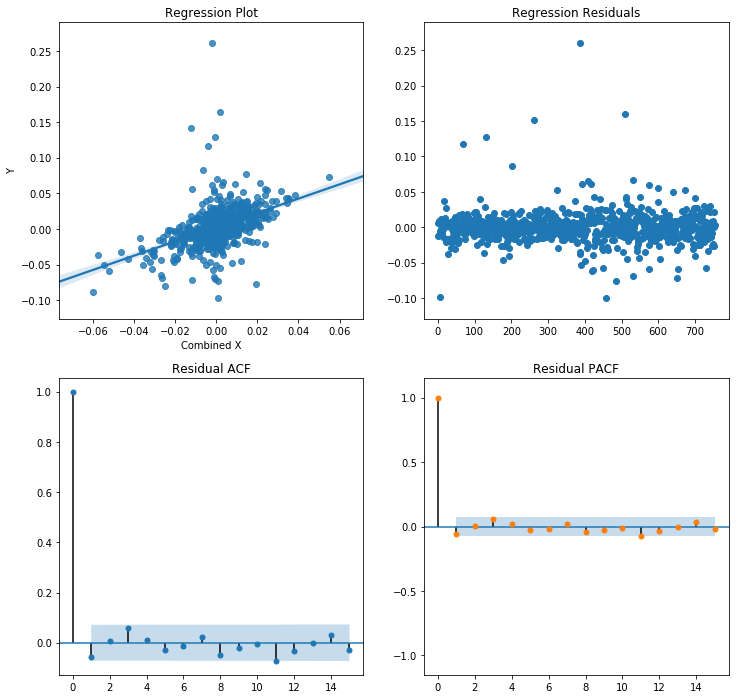

In [18]:
## CAPM
mkt_ret = daily_log_ret_factor['Market'].to_frame()

single_capm_res = lin_reg(Y=single_stock_ret, X=mkt_ret, 
                          print_plots=True, print_summary=True)

**Comment:** not surprisingly, both intercept and beta coefficient from CAPM are significant. The residual does exhibit some heteroskedaticity, which is normal for financial time series. There's little serial correlation in residuals, however, which is a good sign.

CAPM only explains around 21% of the variation - not powerful, but it's a good start. 

#### 3.1.2 Style and industry regression

In [19]:
style_factor = ['Quality','Value','Min Vol','Momentum','Size']
style_ind = pd.concat([daily_log_ret_factor[style_factor], 
                       ind_ret['HiTec']],axis=1).dropna()
calculate_vif(style_ind)

Quality     20.622637
Value       11.161686
Min Vol      8.732857
Momentum     7.244371
Size         1.168528
HiTec        3.135872
dtype: float64

**Comment**: VIF output shows that there is collinearity in *Quality*. As is known, *Quality* emphasizes firm's profitability and earning sustainability. It partially resembles characteristics of *Value* because a comprehensive measure of *Value* incorporates firm's earning potential as well. As the same time, *Quality* can be defensive because it assembles stocks with steady earnings under market downturns. In this regard, it correlates with *Min Vol*. So I decide to exclude *Quality* from the regression and proceed with the rest as exogenous variable.

In [20]:
style_ind_ex_qual = style_ind[style_ind.columns[style_ind.columns!='Quality']]
calculate_vif(style_ind_ex_qual)

Value       6.010819
Min Vol     7.712888
Momentum    5.974256
Size        1.168385
HiTec       3.063619
dtype: float64

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 26 Jun 2018   Prob (F-statistic):                nan
Time:                        00:16:39   Log-Likelihood:                 1845.4
No. Observations:                 755   AIC:                            -3679.
Df Residuals:                     749   BIC:                            -3651.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -0.803      0.4

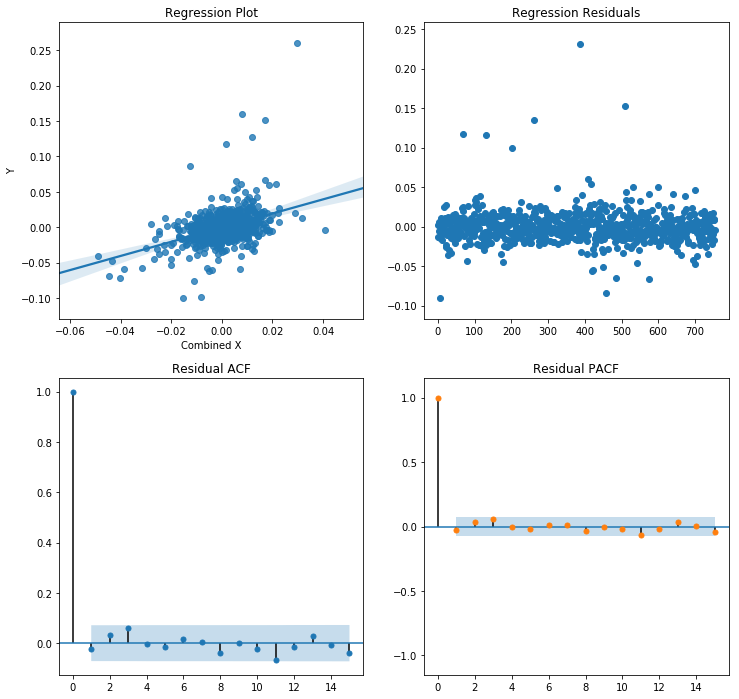

In [21]:
## style + industry
single_style_ind_res = lin_reg(Y=single_capm_res.resid, 
                                X=style_ind_ex_qual, 
                                print_plots=True, 
                                print_summary=True)

**Comment:** the Style-industry regression is able to squeeze out around 17% of variations from the residuals. The intercept is insignificant from zero, as it is mostly stripped out in the first stage regression. Regarding the beta coefficients, *Min Vol* and *Size* are insignificant. This is expected as *Size* proxied by ETF contains only long postions in small cap names and Nvidia is a large cap stock. Meanwhile, Nvidia is often classfied as growth stock, quite in opposite of denfensive stocks that characterize *Min Vol*.

The rest of style factors all exhibits significant coefficients. This can be largely explained by Nvidia being a growth stock from tech sector because 
1. Growth stocks exhibits momentum
2. Value and Growth are (almost) two sides of a coin

The plot below shows the residual time series from the style-industry regression. There is still some variations in the return series and most noticebly, the spikes from time to time. To further separate returns into systematic vs idiosyncratic, a Robust PCA is performed to decompose residuals into a latent, low-rank component  $Z$  and a sparse "shocks" component $S$.

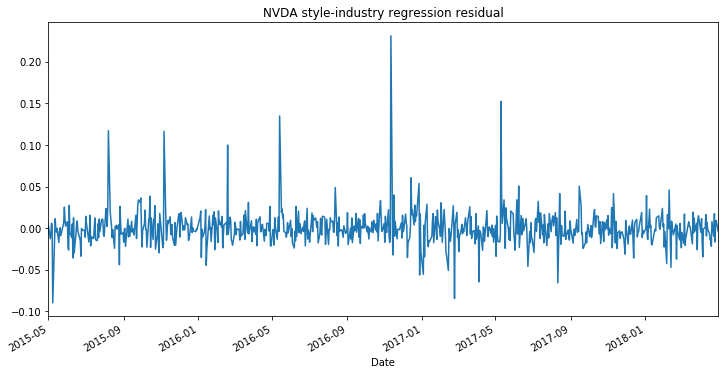

In [22]:
single_style_ind_res.resid.plot(title='NVDA style-industry regression residual',
                                figsize=(12,6))

### 3.2 Robust PCA

The Robust PCA can be formulated as follow:

$$\min_{Z, S} \|Z\|_* + \lambda\|S\|_1 \text{ subject to } A = Z + S$$
, where $\|.\|_*$ is the nuclear norm (i.e. the sum of the singular values) approximating the rank. 

The application here is to decompose a matrix $A$ containing $t$ period returns for $n$ securities into a latent, low-rank component $Z$ which can be thought of as latent factors that explain returns, and a sparse component $S$ which is a idiosyncratic piece. 

In our case, $A$ is an t-by-n matrix of t-horizon residuals time-series of all $n$ tech stocks obtained from the above two stage regressions. In an idea case, the resulted $Z$ will have a $\mathbf{rank}(Z) << n$, representing $\mathbf{rank}(Z)$ latent factors. $S$ will be sparse, representing the idiosyncratic component.

A selected list of $\lambda$ will be used for tuning. Each $\lambda$ corresponds to one set of $Z$ and $S$. 

#### 3.2.1 Robust PCA routines

In [23]:
# CAPM regression for all tech stocks
capm_result = {}
capm_resid = {}

for ticker in all_tech_tickers:
    capm_result[ticker] = lin_reg(Y=daily_log_ret_ticker[ticker], 
                                  X=mkt_ret, 
                                  print_plots=False, 
                                  print_summary=False)
    capm_resid[ticker] = capm_result[ticker].resid
    
capm_resid_df = pd.DataFrame.from_dict(capm_resid)

In [24]:
# style factor regression for all tech stocks
style_result = {}
style_resid = {}

for ticker in all_tech_tickers:
    style_result[ticker] = lin_reg(Y=capm_resid_df[ticker], 
                                   X=style_ind_ex_qual,
                                   print_plots=False, 
                                   print_summary=False)
    style_resid[ticker] = style_result[ticker].resid
    
style_resid_df = pd.DataFrame.from_dict(style_resid)

In [25]:
def robustPCA(A, lamb):
    """
    Performs robust PCA on a real n x p matrix A.
    The argument lamb > 0 represents penalty on l_1 norm.
    
    Returns low-rank matrix and sparse matrix
    """

    S = cvx.Variable(*A.shape)
    
    objective = cvx.Minimize(cvx.norm(A - S, "nuc") + lamb*cvx.norm(S, 1))
    prob = cvx.Problem(objective)
    prob.solve()
    
    Z = A - S.value
    
    return Z, S.value

def approxRank(Z):
    """
    Count number of sv > 1e-6*sigma_max for rank approximation.
    
    Returns an int of approximated rank
    """
    
    sv = np.linalg.svd(Z.values, compute_uv=False)
    
    return (sv > 1e-4*max(sv)).sum()

In [26]:
## Training
lamb_list = [0.1, 0.05, 0.01,0.005]

if not read_from_exiting_output:
    Z_output={}
    S_output={}

    for lamb in lamb_list:
        Z, S = robustPCA(style_resid_df.as_matrix(), lamb)
        Z_output[lamb]=pd.DataFrame(Z,index=style_resid_df.index,columns=style_resid_df.columns)
        S_output[lamb]=pd.DataFrame(S,index=style_resid_df.index,columns=style_resid_df.columns)

In [27]:
## pickle trained file to local
if not read_from_exiting_output:
    pd.to_pickle(Z_output, PATH+'Z_output')
    pd.to_pickle(S_output, PATH+'S_output')
else:
## read trained pickle file from local
    Z_output = pd.read_pickle(PATH+'Z_output')
    S_output = pd.read_pickle(PATH+'S_output')

#### 3.2.2 Robust PCA results for selected companies

Sectors below show the results of Robust PCA for a subset of all tech companies. First is sets of charts, one set for each $\lambda$. The charts include:
1. Raw returns of selected companies as a line chart (top), 
2. Low-rank approximation of selected companies as a line chart (middle), and 
3. Sparse component of the selected companies as a bar chart (bottom)

In an idea scenario, $\mathbf{rank}(Z)<<n$, and $S$ being sparse.




Set of charts for lambda = 0.100


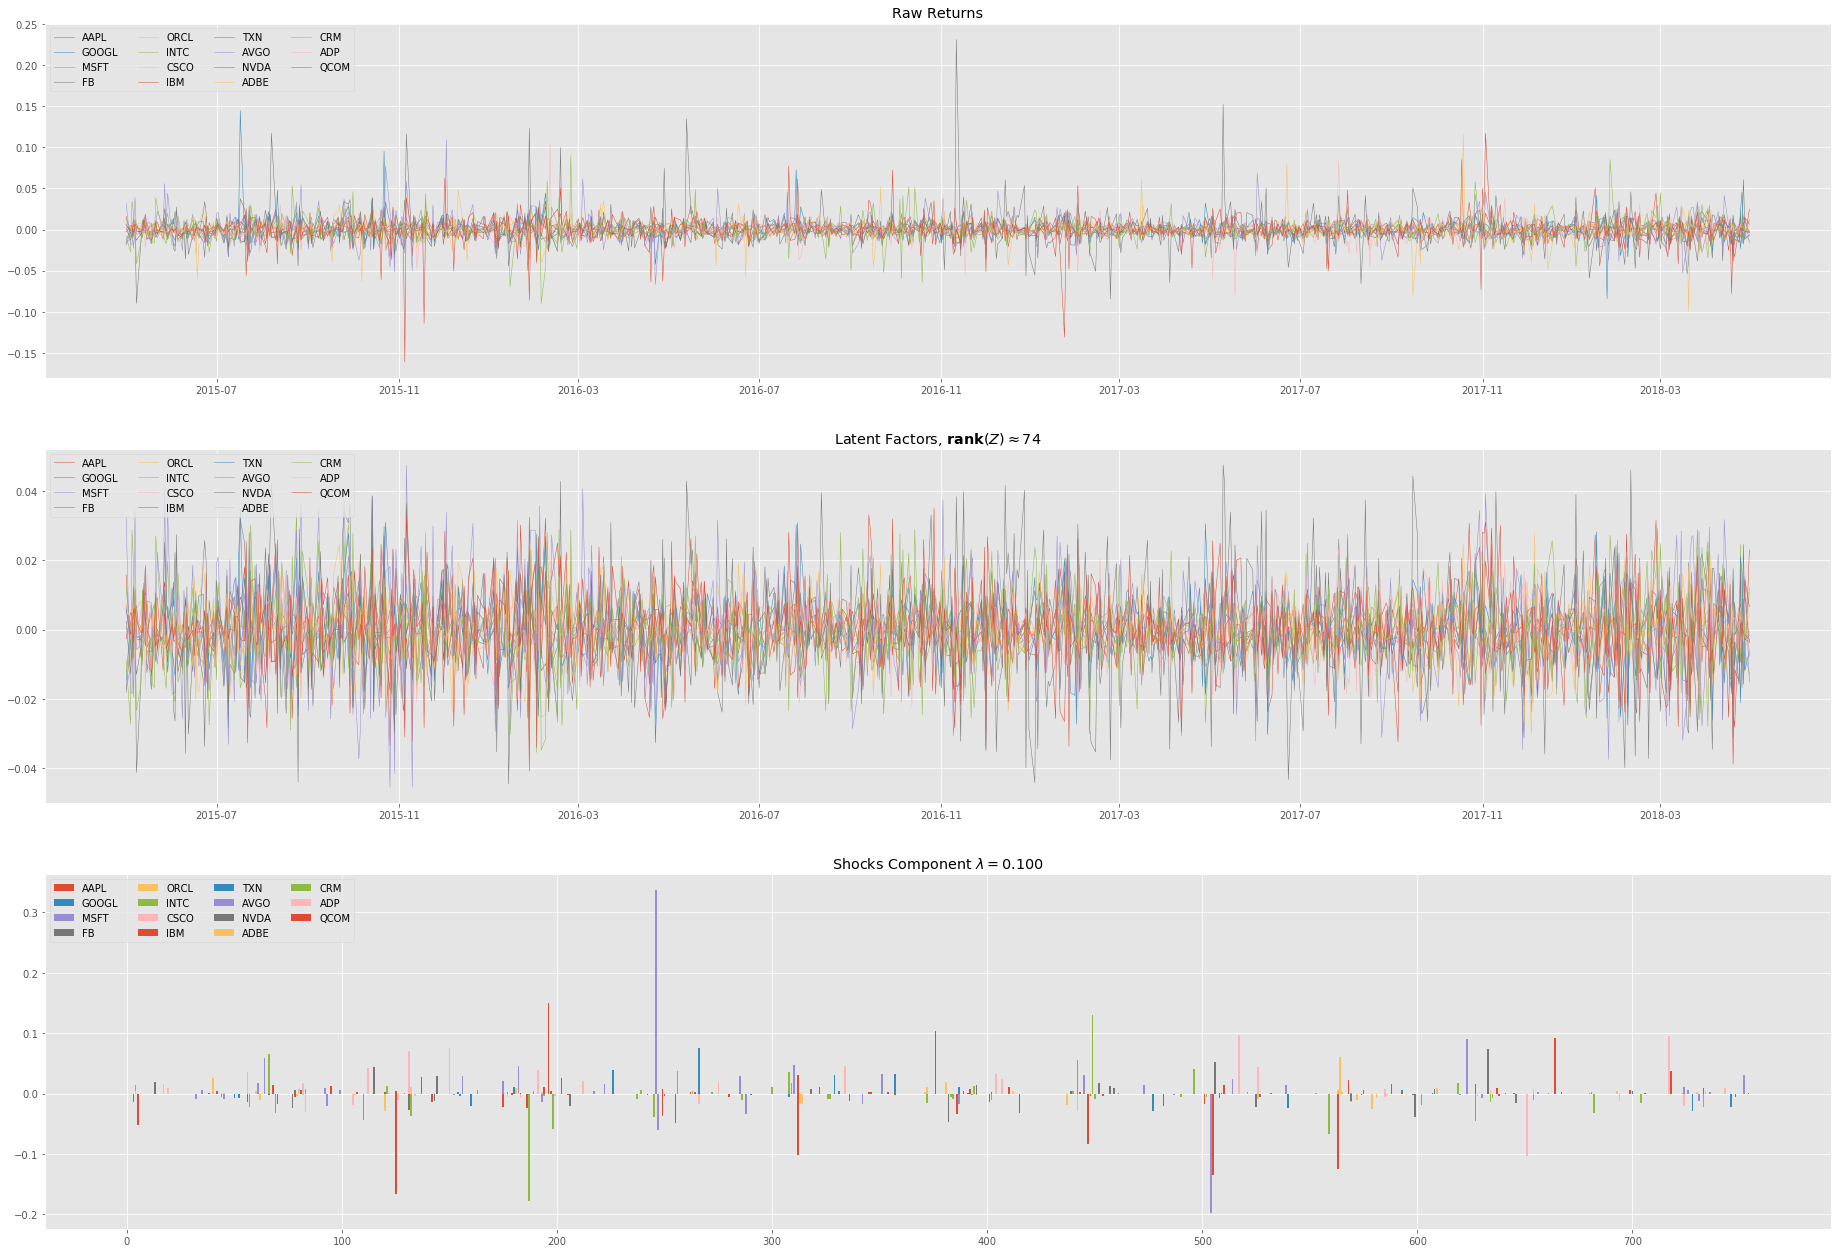




Set of charts for lambda = 0.050


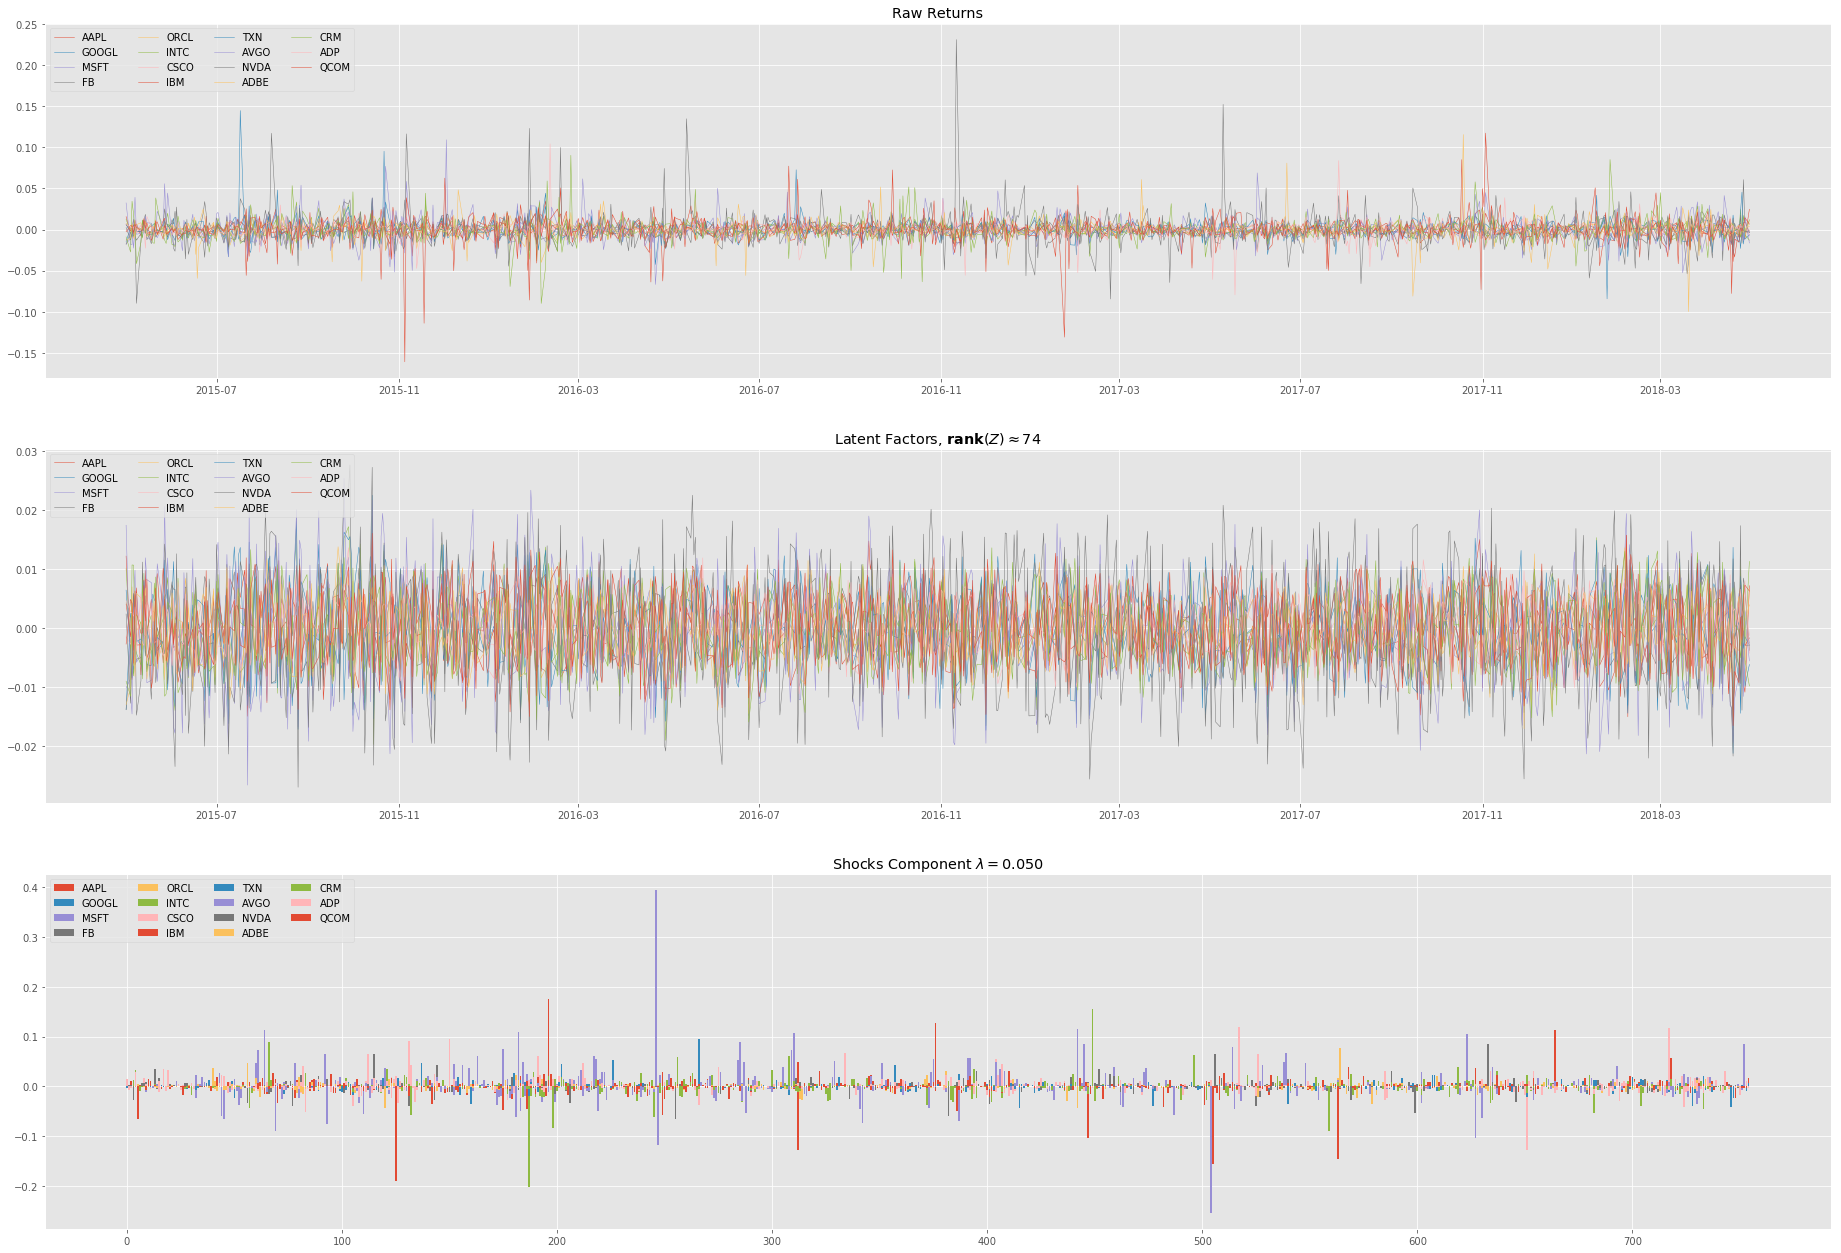




Set of charts for lambda = 0.010


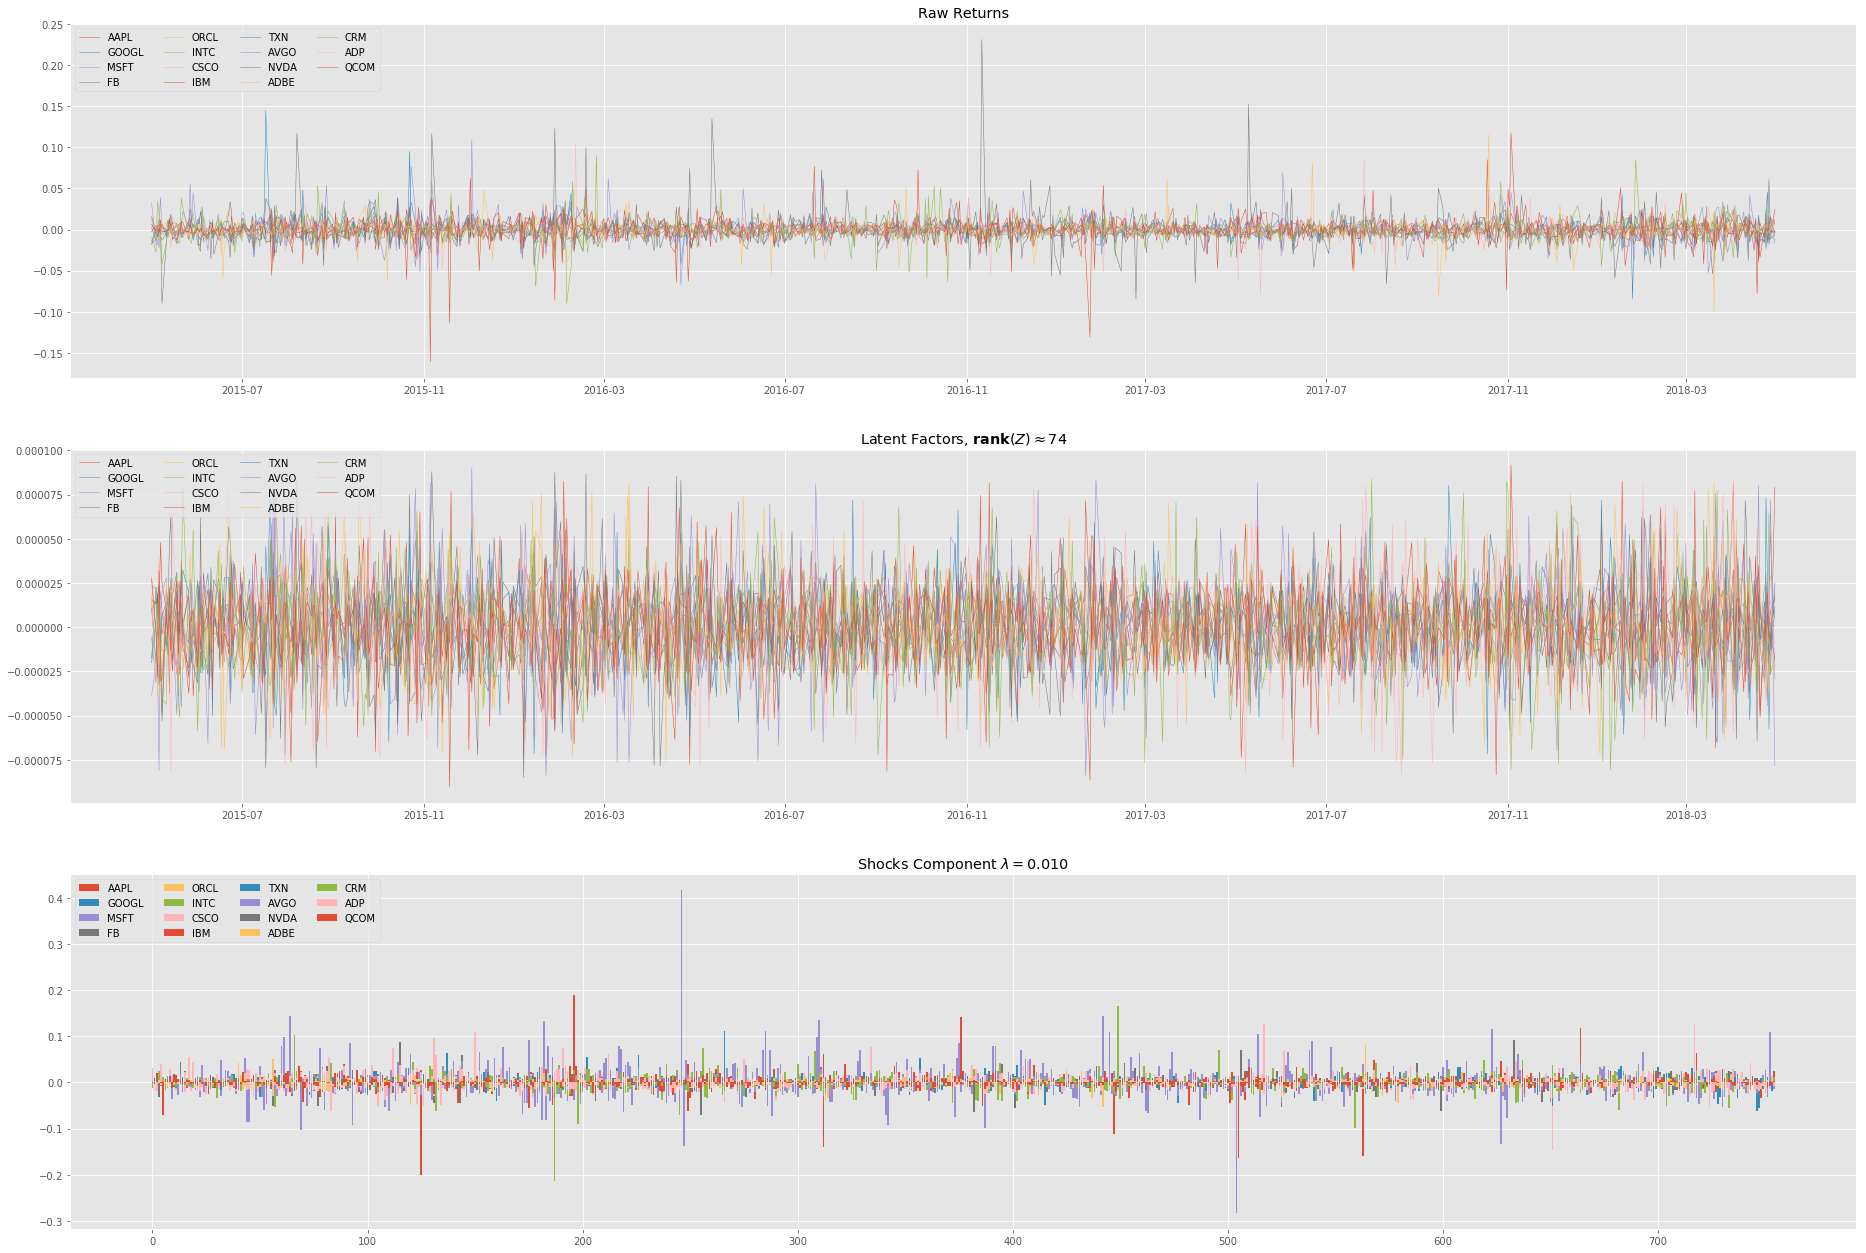




Set of charts for lambda = 0.005


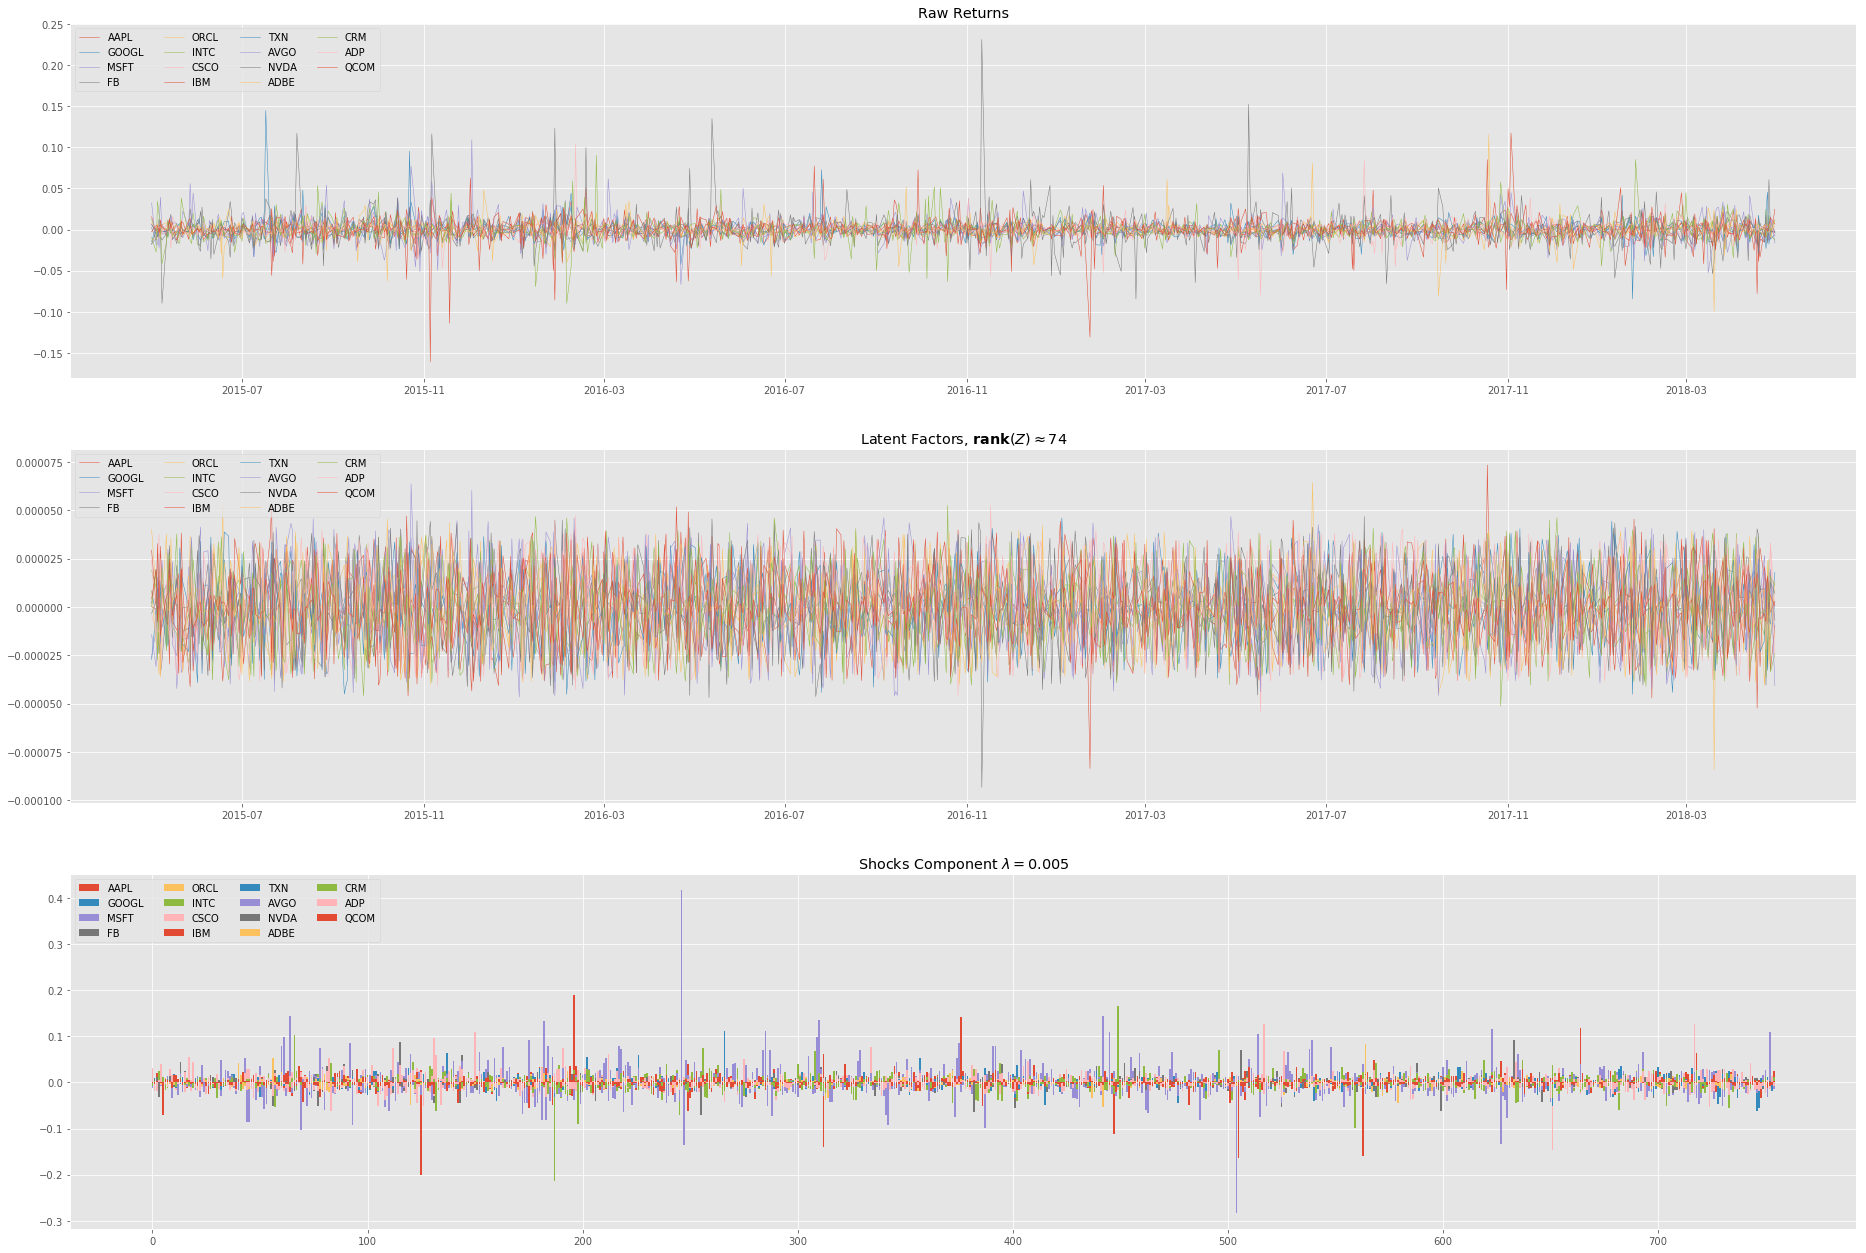

In [28]:
plt.style.use('ggplot')

for idx, lamb in enumerate(lamb_list):
    print('\n\n')
    print 'Set of charts for lambda = %.3f' % lamb
    
    plt.figure(figsize=(32, 30))

    # raw daily return series
    plt.subplot(len(lamb_list), 1, 1)
    for company in ticker_subset:
        plt.plot(style_resid_df[company], label=company, linewidth=.5)
    plt.title('Raw Returns')
    plt.legend(loc='upper left', ncol=4)


    # low rank returns
    plt.subplot(len(lamb_list), 1, 2)
    for company in ticker_subset:
        plt.plot(style_resid_df.index, Z_output[lamb][company], linewidth=.5,label=company)
    plt.title(r'Latent Factors, $\mathbf{rank}(Z) \approx %i$' % approxRank(Z_output[lamb]))
    plt.legend(loc='upper left', ncol=4)

    # sparse returns
    plt.subplot(len(lamb_list), 1, 3)
    S = np.array(S_output[lamb])
    grid = np.arange(S.shape[0])
    for col_num, company in enumerate(style_resid_df[ticker_subset]):
        plt.bar(grid, S[:, col_num], label=company)

    plt.title(r'Shocks Component $\lambda = %.3f$' % lamb)
    plt.legend(loc='upper left', ncol=4)
    plt.show()

**Comment:** It appears that the $rank(Z)$ is not reduced at all. This is in fact a known drawbacks of using Robust PCA for low-rank approximation, as $\|.\|_*$ is only an approximation for rank. However, judging from charts, $Z$ does capture a lot of co-variation of the selected tech stocks, as most of the time series in the middle plot oscillates within a tight band. This can be qualitatively classified as 'sysematic' variation within the sector.

Luckily the sparse component does appear to be quite sparse, even when $\lambda$ is low. I eventually choose $\lambda = 0.05$ to strike a balance between sparsity and having little variation.

#### 3.2.3 Further investigation on Robust PCA results - sparsity and earning surprises

Below I retrieved the sparse component of Nvidia from $S$ in attempt to look for patterns. Noticeably the spikes appear almost every 3 months. It seems to coinside with earning release date of Nvidia. I sorted the sparse return in descending order and observed that largest return appears repeatedly in May, August and November.

A positive spike could possibly indicates an earning suprise at annoucement, while negative spike a disappointment. I extracted the earning surprise data from Zacks.com and aligned it with the sparse return. Below I intended to investigate this hypothesis further. 

In [29]:
lamb = 0.05

latent_factor_ret = Z_output[lamb]
single_stock_lret = latent_factor_ret[stock_of_interest]
sparse_ret = S_output[lamb]
single_stock_sret = sparse_ret[stock_of_interest]

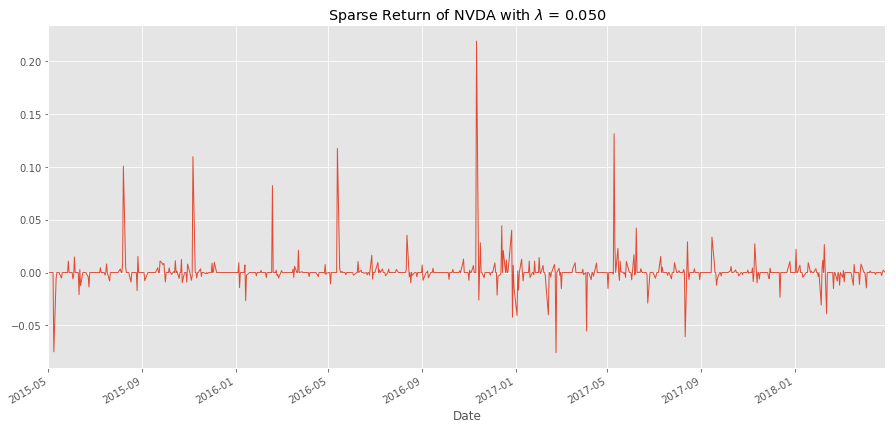

In [30]:
single_stock_sret[abs(single_stock_sret)< 1e-4] = 0
single_stock_sret.plot(lw=1,figsize=(15,7),
                       title='Sparse Return of %s with $\lambda$ = %.3f' 
                       % (stock_of_interest,lamb))

In [31]:
sorted_series = single_stock_sret[single_stock_sret!=0].sort_values(ascending=False)

pd.DataFrame(sorted_series.values,
             index = sorted_series.index,
             columns=['Sparse return']).tail(10)

Sparse return
Date                     
2017-06-23      -0.028955
2018-02-05      -0.030787
2018-02-12      -0.038944
2017-02-13      -0.039997
2017-01-03      -0.040652
2016-12-28      -0.042249
2017-04-04      -0.055448
2017-08-11      -0.060693
2015-05-08      -0.075032
2017-02-23      -0.075819

In [423]:
earning_surprise = pd.read_excel(PATH+'nvda_earning_surprise.xlsx',index_col=0,parse_dates=True)

In [424]:
sparse_vs_surprise = single_stock_sret.to_frame('Sparse')
sparse_vs_surprise['Surprise'] = earning_surprise['Surprise']
sparse_vs_surprise.fillna(0,inplace=True)

In [425]:
surprised_date = sparse_vs_surprise.Surprise[sparse_vs_surprise.Surprise!=0].index
sparse_date = sparse_vs_surprise.Sparse[abs(sparse_vs_surprise.Sparse)>0.05].index

hit_ratio = float(len(list(set(surprised_date) & set(sparse_date))))/len(sparse_date)

print 'Hit ratio of earning surprise coinsides with sparse return whose absolute magnitude greater than 0.05: %.2f' % hit_ratio

Hit ratio of earning surprise coinsides with sparse return whose absolute magnitude greater than 0.05: 0.80


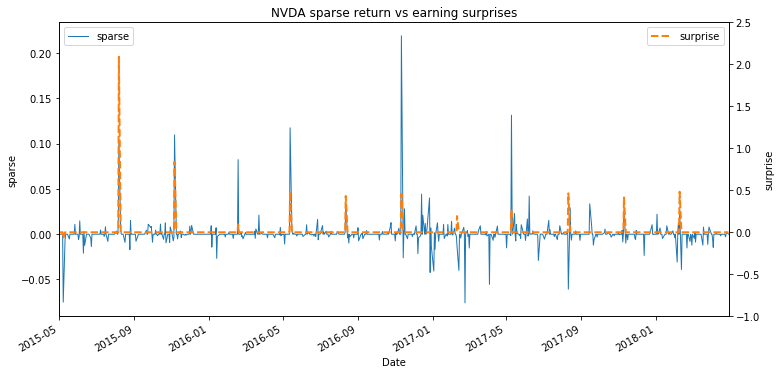

In [426]:
plt.figure(figsize=(12,6))
ax1 = sparse_vs_surprise.Sparse.plot(lw=1)
ax2 = sparse_vs_surprise.Surprise.plot(secondary_y=True,lw=2,style='--')

ax1.set_ylabel('sparse')
ax1.legend(['sparse'],loc=2)
ax2.set_ylabel('surprise')
ax2.legend(['surprise'],loc=1)
ax2.set_ylim(-1,2.5)
plt.title('NVDA sparse return vs earning surprises')

**Comment:** Almost all earning spikes coincide with large spare return spikes (whose absolute magnitude greater than 0.05), with a hit ratio of 80%. While not capturing all the shocks, it could serves as a reasonable timing approximation. Also noted is that the level and variation of spikes is not fully captured by the surprises. This could be because the earning surprise of one single firm is not comprehensive enough to capture the correlation with the sector or market earning surprises. Also, under different economic regime, the surprise factor might be suppressed or magnified. 

Nevertheless, it does not hurt to run a regression against its earning surprises. The earning surprises here is similar to a binary variable - 0 everywhere except for earning annoucement date. Below is the regression output. The result shows that the beta coefficient is significant, and R-square being 16.5%. This is a reasonable approximation for shocks, considering the variable contains almost only zero everywhere.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 26 Jun 2018   Prob (F-statistic):                nan
Time:                        18:53:22   Log-Likelihood:                 1913.8
No. Observations:                 755   AIC:                            -3824.
Df Residuals:                     753   BIC:                            -3814.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.182      0.2

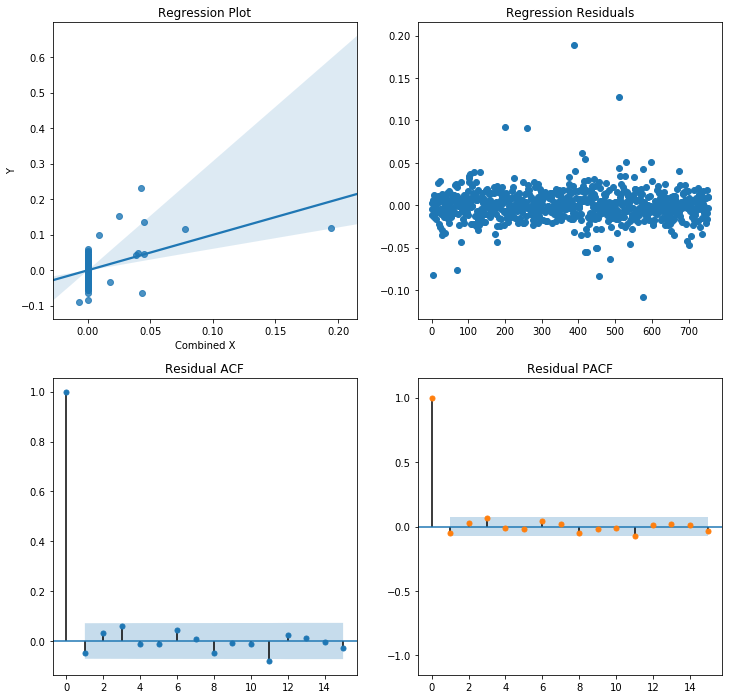

In [427]:
lin_reg(Y=single_style_ind_res.resid, X=sparse_vs_surprise['Surprise'], print_plots=True, print_summary=True)

## 4. Conclusion

The problem is to investigate single stock $i$'s contemporaneous return $r_{i,t}$ at time t. I modeled the daily return of Nvidia as a combination of systematic return and idiosyncratic return in a top down framework. The systematic piece is carried out under a multi-factor framework. It consists of two stage of regressions: first stage is the standard CAPM, its residual is regressed against style factors and industry returns in the second stage. The factor pool contains the following factors: *Value*, *Momentum*, *Quality*, *Size*, *Min Vol* and *Market*. From the two stage framework, it is observed that *Market* together with *Value*, *Momentum* and *Industry* together can explain some systematic variation of the return (with R-square 21% and 17%, respectively in each regression). 

In an attempt to further investigate the systematic component, I performed the same two stage regression on all tech stocks, retrieved the residual and applied Robust PCA, with hope to find a low rank approximation of latent factors. However, due to limitations of Robust PCA, the low rank matrix could not be retrieved successfully. 

Nevertheless, the other output from Robust PCA provided some insights about the sparse returns or shocks. Most of the dominant shocks coincided with the earning surprises. I therefore run another regression of Nvidia two-stage residuals against earning surprises. The result showed the earning surprises has some explanation power. It's not perfect of course, as spikes on earning annoucement are also correlated to peers earning and the overall market and economic dynamics.

In sum, to model the contemporaneous return on daily horizon, I would use a two-stage multifactor framework as discussed above and at earning day factoring in the surprise from earning release. 

## 5. Future Steps
1. All style factor data uses ETF as proxies. This may cause some collinearity and may lack in explanation power compared to classical long-short factors. If there are sources for clean raw factor data it would be helpful.
2. All regressions a single period. If given more time, I would modify the regressions (and subsequent PCAs) to perform on a rolling basis, as the betas are time varying. I would also consider using Kalmann filter.
3. There are better but more complicated ways to perform low rank approximation. Robust PCA failed half of its purpose. However, a lot of statistical learning approaches are poor in interpretability. If I had more time I would explore more options here (maybe constructing different factors).
4. Construct more comprehensive earning surprise factors that incorporate sector/market dynamics and economic regimes.

## 6. Extensions

Sections below I explored and evaluated possible extensions of this research project in areas listed in Section 5 Future Steps. I will look at different ways to summerize relationships between single stock return of Nvdia and the pool of factors. Specifically, I used rolling window regression and Kalman filter as alternatives for OLS in the two-stage regression, and PCA to try to force low reduction as opposed to Robust PCA. Additionally, I will present a possible improvement in explaining daily return shocks related to earning surprises. 

The factor pool consists of the same factors as the initial draft. They are *Value*, *Momentum*, *Quality*, *Size*, *Min Vol*, and *Market*. The data source for *Value*, *Momentum*, *Size*, and *Market* uses the Fama-French database. Among them, the style factors are effectively long-short portfolios, and the *Market* includes a wider universe. Data for *Quality* and *Min Vol* still uses corresponding ETFs as proxies, as there is no easily accessible alternative data source.

### 6.1 Earning surprise and short term economic states

It is natural to think investors are more optimistic under expansion and therefore reacts to shocks more optimistically. The opposite is also true. This also fits the rationale of risk premium that in good times investors demands less premium to hold a stock and as a result the present price edges higher and in bad times the reverse holds. An good metric to assess the economic state and business cycle is the Leading Index for the United States. It is a monthly leading index that models six-month growth rate of the state’s coincident index as well as other variables that lead the economy such as state-level housing permits. This should capture investors expectation of near term economic growth.

I plan to categorize the monthly economy environment in three states: slowdown, neutral and expansion. To determine the state of a particular month, I first calculated a rolling mean $\mu_{12}$ and standard deviation $\sigma_{12}$ of past 12 months. If the current index level is greater than $\mu_{12}+\sigma_{12}$, the month will be classified as in 'economic expansion'. If it is below $\mu_{12}-\sigma_{12}$, it will be categorized as slowdown. If in between, it is treated as neutral. Both expansion and slowdown will be added to the regression against earning surprise as binary variables with synced time stamp. Hopefully the regression result will show significant improvements.

The data source of Leading Index for the United States is St.Louis Fed website.

#### 6.1.1 Preparing data

In [37]:
usslind = pd.read_csv(PATH + 'USSLIND.csv',index_col=0,parse_dates=True)

In [38]:
above_std = (usslind - usslind.rolling(12).mean()-1*usslind.rolling(12).std()).resample('QS-FEB').first().tail(12)
above_std = (above_std > 0)*1
below_std = (usslind - usslind.rolling(12).mean()+1*usslind.rolling(12).std()).resample('QS-FEB').first().tail(12)
below_std = (below_std < 0)*1

In [420]:
## time stamp sync

expansion = pd.Series(np.squeeze((above_std.fillna(0)).values),
                         index = earning_surprise.sort_index().index[2:-1],
                         name='expansion')

slowdown = pd.Series(np.squeeze((below_std.fillna(0)).values),
                         index = earning_surprise.sort_index().index[2:-1],
                         name='slowdown')

In [428]:
surprise_econ_state = sparse_vs_surprise.Surprise.to_frame().copy()
surprise_econ_state['expansion'] =  expansion
surprise_econ_state['slowdown'] =  slowdown
surprise_econ_state.fillna(0,inplace=True)

#### 6.1.2 Augmented earning surprise regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 26 Jun 2018   Prob (F-statistic):                nan
Time:                        18:53:41   Log-Likelihood:                 1974.2
No. Observations:                 755   AIC:                            -3940.
Df Residuals:                     751   BIC:                            -3922.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.602      0.1

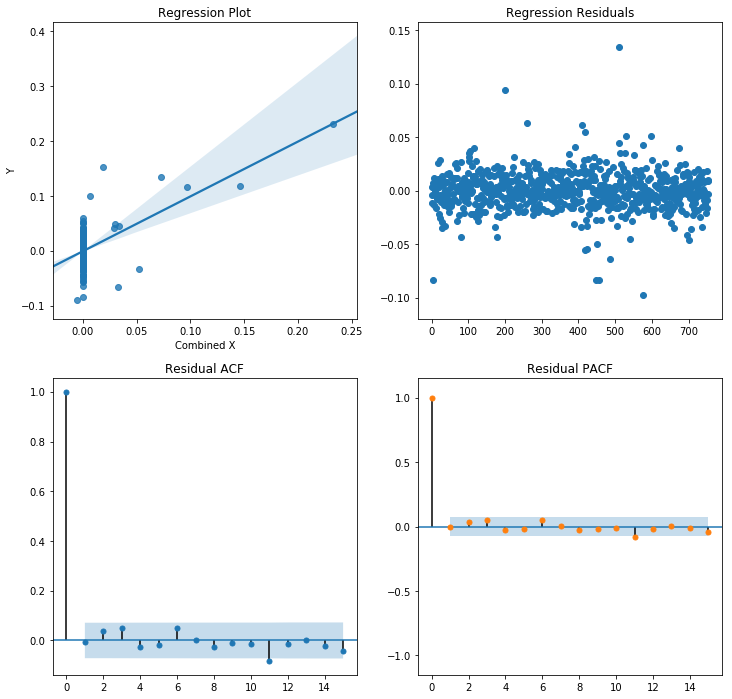

In [429]:
res = lin_reg(Y=single_style_ind_res.resid, X=surprise_econ_state, print_plots=True, print_summary=True)

The result overall looks promising. The R-squared almost doubled from 16.6% to 28.9%. The 'Expansion' variable is strongly significant, but the 'Slowdown' lacks significance. The theory seem to hold some ground here, except that the 'economic slowdown' doesn't seem to correct for negative shocks very well. 

Further digging suggests this approach has one issue that should not be overlooked. The sample size for 'expansion' and 'slowdown' is too small. Specifically, using a 12-month window the sample has only one 'expansion' in the month of earning release and three 'slowdowns' (see dataframe below). It just so happened that the only month of 'expansion' coincide with the largest postive shock, which explains the huge improvements in R-squared. This could be pure coincidence or data mining. Longer history is needed to properly examine this theory. 

It seems the problem remains that the level is unmatched by earning surprise. There could be a few reasons:
1. The earning surprise is calculated using Zacks' own estimate rather then the consensus. It may contain bias and noise and not representative enough. 
2. Shocks on earning release date are also related to investors' expectation on fundamentals, which are not entirely captured as earning surprises is more of a sentiment factor. 
3. There might be 'smart' money entering taking advantage of positive sentiment: buying slow and sell high. It would be interesting to investigate the price and volume data in minute or five-minute intervals to see if there are big orders flowing in. 

At some point, there are specific events happening at specific time, which cannot be easily modelled using purely systematic approach. I believe I went as far as you could with the data available from a systematic perspective. 

In [433]:
## expansion vs slowdown binary indicator
pd.concat([expansion,slowdown],axis=1)

expansion  slowdown
Date                           
2015-05-08          0         0
2015-08-07          0         0
2015-11-06          0         1
2016-02-18          0         0
2016-05-13          0         1
2016-08-12          0         0
2016-11-11          1         0
2017-02-10          0         1
2017-05-10          0         0
2017-08-11          0         0
2017-11-10          0         0
2018-02-09          0         0

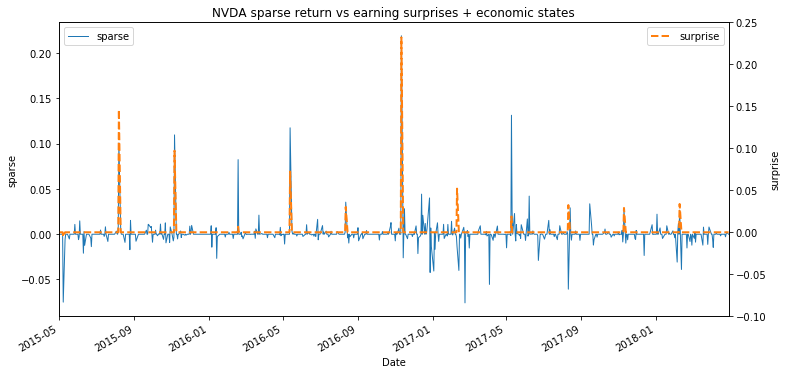

In [434]:
res_to_plot = pd.concat([(surprise_econ_trend*res.params).dropna(axis=1).sum(axis=1),
                         sparse_vs_surprise.Sparse.to_frame()],axis=1)

plt.figure(figsize=(12,6))
ax1 = res_to_plot.Sparse.plot(lw=1)
ax2 = res_to_plot[0].plot(secondary_y=True,lw=2,style='--')

ax1.set_ylabel('sparse')
ax1.legend(['sparse'],loc=2)
ax2.set_ylabel('surprise')
ax2.legend(['surprise'],loc=1)
ax2.set_ylim(-0.1, 0.25)
plt.title('NVDA sparse return vs earning surprises + economic states')

### 6.2 Rolling beta and Kalman filter

One major drawback of applying multi-factor model to explain individual stock return is the volatility in factor exposure estimates. Even in case of simple factor model such as CAPM, the betas are known to vary with time. This section attempts to explore the relationship between single stock return and factors in a dynamic setting. 

In sample fit of the model is evaluated in $R^2$. There are other useful metrics such as AIC and BIC. For Kalman filter I tried to compute AIC and BIC using the package likelookhood function but it seems buggy and there is no easy fix. Therefore only $R^2$ is reported.

#### 6.2.1 Data imports from Fama-French website

(I realized in the previous section I forgot to subtract daily risk free rate in the CAPM regression. Though I had implemented a corrected version, the difference in results were negligible. So I leave the initial draft untouched as one piece (treating it as a single market factor model) and focus solely on the extension.)

In [331]:
ff_3factor_data = pd.read_csv(PATH+'F-F_Research_Data_Factors_daily.CSV',
                              skiprows=4,header=0,index_col=0,parse_dates=True,skipfooter=2)
ff_mom = pd.read_csv(PATH+'F-F_Momentum_Factor_daily.CSV',
                     skiprows=13,header=0,index_col=0,parse_dates=True,skipfooter=2)
ff_mom.columns = ['MOM']

/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  
/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [333]:
ff_3factor_data = ff_3factor_data.loc[start_date:end_date,:]/100
ff_mom = ff_mom.loc[start_date:end_date,:]/100
ff_hitec = ind_ret.loc[start_date:end_date,'HiTec']

In [347]:
all_exog = pd.concat([ff_3factor_data,ff_mom,ff_hitec,daily_log_ret_factor[['Quality','Min Vol']]],axis=1).dropna()
excess_ret = all_exog['Mkt-RF']
rf = all_exog['RF']
calculate_vif(all_exog)

Mkt-RF     38.681193
SMB         2.386678
HML         1.400712
RF          1.009342
MOM         1.272506
HiTec       9.474233
Quality    29.492181
Min Vol     8.298369
dtype: float64

**Comment:** similar as before, there exists strong multicollinearity in *Market* and *Quality*. The treatment stays the same: the two-stage regression will be implemented where the first stage is the standard CAPM and second stage against *Industry* and ex-Quality *Style* factors.

#### 6.2.2 Rolling window regression

Below is the implementation of rolling window regression. Apart from OLS regression, it has the option to run Robust Linear Models. The reason to include this option in here is because OLS regression cannot handle outliers very well.As is known, single stock return from time to time can be a little extreme as there are market shocks that drive prices outrageously high or low. Having the ability to perform RLM is a nice extension. The robust criterion by default is Huber’s T.

In [595]:
def r_squared(y,y_fitted):
    """
    Calculates R-squared based on y and its fitted value
    """
    
    ybar = np.sum(y)/len(y)
    ssreg = np.sum((y_fitted-ybar)**2)
    sstot = np.sum((y - ybar)**2)
        
    return ssreg / sstot

def regression_roll(Y, X, window, add_const=False, rlm=False):
    """
    Rolling regression Y~X with look back window 'window'
    
    Returns coeffcients and confidence interval for each regression, 
        stand errors of regression coefficients, 
        and statsmodel regression object
    
    """
    date_index = Y.index[window-1:]
    
    if add_const:
        X = sm.add_constant(X)
        
    if isinstance(X,pd.DataFrame):
        columns = X.columns
    
    x=[(X.values[i:i+window,:]) for i in range(len(X)-window+1)]
    y=[(Y.values[i:i+window]) for i in range(len(Y)-window+1)]
    if not rlm:
        ls_r = [sm.OLS(y[i],x[i]).fit(cov_type='HC0') for i in range(len(x))]
    else:
        ls_r = [sm.RLM(y[i],x[i]).fit() for i in range(len(x))]
    
    b = np.asarray([ls_r[i].params for i in range(len(ls_r))])
    se = np.asarray([ls_r[i].cov_params() for i in range(len(ls_r))])
    
    conf_dict = {date: pd.DataFrame(ls_r[i].conf_int(),
                                     columns=['lower','upper'],
                                     index=columns).T for i, date in enumerate(date_index)}
    
    b = pd.DataFrame(b,date_index,columns)
    se = pd.Panel(se,date_index)
    
    conf_panel = pd.Panel.from_dict(conf_dict).swapaxes(1,0)
    conf_panel['params'] = b
    conf_panel = conf_panel.swapaxes(2,0)
    
    r_sqr = r_squared(Y.values[window-1:], np.sum(b.values*X.values[window-1:],axis=1))
    
    return conf_panel, r_sqr, ls_r

<ipython-input-595-2ff1768f3898>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(y)==len(y_fitted), 'Dimension mismatch')


In [598]:
conf_panel_30, r_sqr_30, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=30)
conf_panel_60, r_sqr_60, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=60)
conf_panel_120, r_sqr_120, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=120)
conf_panel_180, r_sqr_180, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=180)

/Users/Norman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


##### 6.2.2.1 Rolling CAPM with different look back window

As it will be shown below, different span of rolling window can change beta drastically. The trend of beta seems to stablize when the window size is over 120. Naturally the question becomes what look back window is optimal for our purpose. One would tempt to use R-squared as a metric of fit and select the optimal time span that maximizes the fit by trying a steam of different values (essentially a grid search). This approach will for certain end up choosing a span of 2, as 2 points can fit a line perfectly, therefore resulting in a artificially high R-squared of 100%. If the sample size is too small, it defeats the purpose of regression.

Another thing to consider is smoothness of beta. It exhibits trends and offers insights about its short term market exposure change. Using the 120 Day rolling window as an example, we see that its beta most of the times stays below 1. Since Nvidia is usually treated as a growth stock, a beta above 1 seems logical. It reaches its peak above a staggering 2.5 by the end of 2017 and exhibits mean reversion post 2017. This can be explained by the strong performance of Nvidia in 2017 when its stock price more then doubled. As it comes to 2018, it experienced a slow down - many say it is due to a tempering demand from cryptocurrency miners.

One concern for choosing an arbitrary rolling window is the ambiguity. It does not have a good mathematical or economic meaning attached. As an alternative which will be more closely examined in later sections, Kalman have better interpretability in parameters mathematically. Also the use of Bayesian online updating makes more logical sense and it's less computationally expensive.

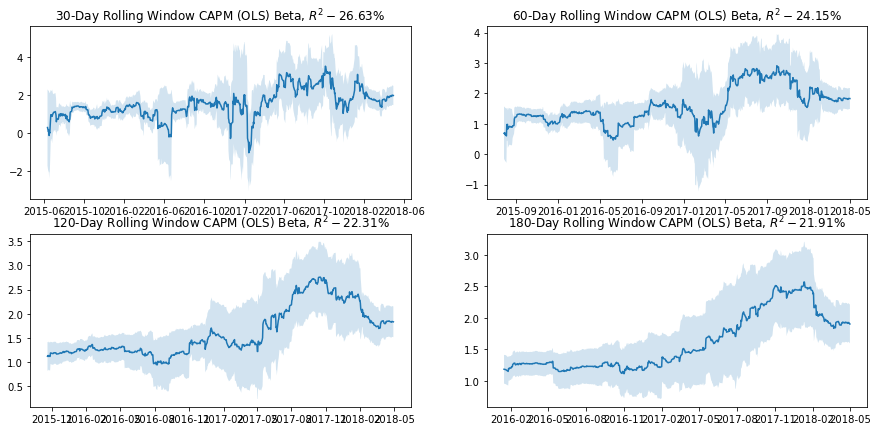

In [1168]:
fig,ax = plt.subplots(2,2,figsize=(15,7))

coef = conf_panel_30['Mkt-RF'].copy()
ax[0,0].plot(coef.index, coef.params)
ax[0,0].fill_between(coef.index, coef.lower, coef.upper,  alpha=0.2)
ax[0,0].set_title('30-Day Rolling Window CAPM (OLS) Beta, $R^2 - %.2f$%%' % (r_sqr_30*100))

coef = conf_panel_60['Mkt-RF'].copy()
ax[0,1].plot(coef.index, coef.params)
ax[0,1].fill_between(coef.index, coef.lower, coef.upper,  alpha=0.2)
ax[0,1].set_title('60-Day Rolling Window CAPM (OLS) Beta, $R^2 - %.2f$%%' % (r_sqr_60*100))

coef = conf_panel_120['Mkt-RF'].copy()
ax[1,0].plot(coef.index, coef.params)
ax[1,0].fill_between(coef.index, coef.lower, coef.upper,  alpha=0.2)
ax[1,0].set_title('120-Day Rolling Window CAPM (OLS) Beta, $R^2 - %.2f$%%' % (r_sqr_120*100))

coef = conf_panel_180['Mkt-RF'].copy()
ax[1,1].plot(coef.index, coef.params)
ax[1,1].fill_between(coef.index, coef.lower, coef.upper,  alpha=0.2)
ax[1,1].set_title('180-Day Rolling Window CAPM (OLS) Beta, $R^2 - %.2f$%%' % (r_sqr_180*100))

##### 6.2.2.2 Rolling beta time series properties

Below is a quick examination of some time series properties of rolling beta estimates. The sample I picked is from the 30-day rolling window. From ACF and PACF plots it exhibits some level of persistency, especially in the PACF plot where the first lag is almost 1. This appears to share some similarities with random walk. My ADF tests also rejects the beta being stationary. 

By applying the first difference it shows that the first difference of beta estimates acts like white noise. Judging from the evidence, $\beta_{t} = \beta_{t-1} + \sigma_{wn}$ seems to be a simple yet accurate model to use. Indeed, the beta estimates of signal stock in short time frame is very volatile. It might be better to use some online learning techniques to better capture the dynamics.

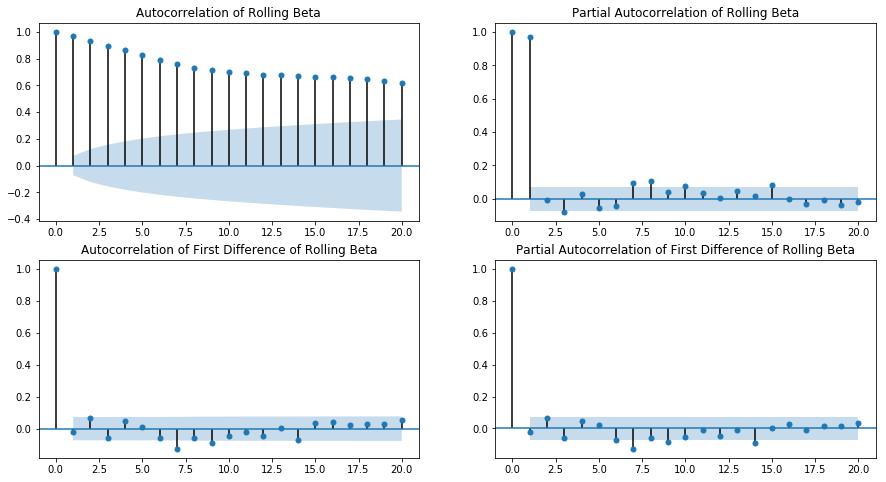

In [631]:
fig2,ax2=plt.subplots(2,2,figsize=(15,8))
roll_beta = conf_panel_30['Mkt-RF'].params
first_diff_roll_beta = roll_beta.diff().dropna()

c = plot_acf(roll_beta,lags=20, ax=ax2[0,0], title='Autocorrelation of Rolling Beta')
d = plot_pacf(roll_beta,lags=20, ax=ax2[0,1], title = 'Partial Autocorrelation of Rolling Beta')
a = plot_acf(first_diff_roll_beta,lags=20, ax=ax2[1,0], title='Autocorrelation of First Difference of Rolling Beta')
b = plot_pacf(first_diff_roll_beta,lags=20, ax=ax2[1,1], title = 'Partial Autocorrelation of First Difference of Rolling Beta')

In [696]:
stationarity_test(roll_beta)

ValueError: Cannot reject the null hypothesis at 0.05 level that the series is stationary

In [633]:
stationarity_test(first_diff_roll_beta)

##### 6.2.2.3 Rolling CAPM  - OLS vs RLM comparison in different rolling windows

Single day stock returns are more prone to outliers and extreme values. Robust linear models can be of great help here as they handles outliers relatively well. As is seen below, betas are less extreme and there is less oscillation. Robustness is a great feature to have because the main purpose here is to extract systematic information and leave out idiosyncratic noises which are the extreme values and outliers. In terms of $R^2$ the two has little difference. In daily return modelling I would choose RLM over OLS.

However, RLM poses the challenge of tuning. There are many linear models available for disposal and yet each has its own set of parameters. It is difficult to quantify (at least to me) which of these models works the best. Also, it shares a similar difficulty of selecting an optimal rolling window. In the next section I will examine the application of Kalman filter as a (better) alternative.

In [1176]:
conf_panel_30_rlm, r_sqr_30_rlm, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=30, rlm=True)
conf_panel_60_rlm, r_sqr_60_rlm, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=60, rlm=True)
conf_panel_120_rlm, r_sqr_120_rlm, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=120, rlm=True)
conf_panel_180_rlm, r_sqr_180_rlm, _ = regression_roll(Y=single_stock_ret-rf, X=sm.add_constant(excess_ret), window=180, rlm=True)

In [1183]:
print '************** R-squared comparison OLS vs RLM **************'
print
print '30 Day Rolling Window R-squared OLS vs RLM:  %.2f%% - %.2f%%' % (r_sqr_30*100, r_sqr_30_rlm*100)
print '60 Day Rolling Window R-squared OLS vs RLM:  %.2f%% - %.2f%%' % (r_sqr_60*100, r_sqr_60_rlm*100)
print '120 Day Rolling Window R-squared OLS vs RLM: %.2f%% - %.2f%%' % (r_sqr_120*100, r_sqr_120_rlm*100)
print '180 Day Rolling Window R-squared OLS vs RLM: %.2f%% - %.2f%%' % (r_sqr_180*100, r_sqr_180_rlm*100)
print
print '*************************************************************'

************** R-squared comparison OLS vs RLM **************

30 Day Rolling Window R-squared OLS vs RLM:  26.63% - 25.79%
60 Day Rolling Window R-squared OLS vs RLM:  24.15% - 23.91%
120 Day Rolling Window R-squared OLS vs RLM: 22.31% - 21.92%
180 Day Rolling Window R-squared OLS vs RLM: 21.91% - 21.23%

*************************************************************


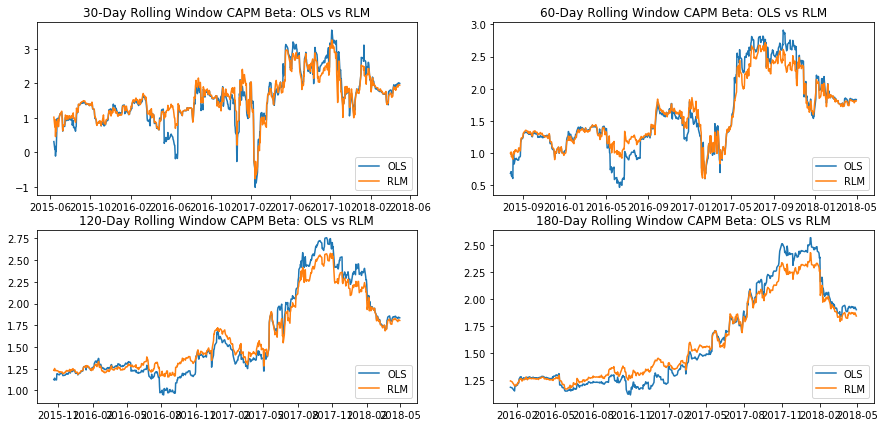

In [559]:
fig2,ax = plt.subplots(2,2,figsize=(15,7))

coef = conf_panel_30['Mkt-RF'].copy()
ax[0,0].plot(conf_panel_30['Mkt-RF'].params, label='OLS') #,'b'
ax[0,0].plot(conf_panel_30_rlm['Mkt-RF'].params, label='RLM') #,'b'
ax[0,0].legend(loc='lower right')
ax[0,0].set_title('30-Day Rolling Window CAPM Beta: OLS vs RLM')

ax[0,1].plot(conf_panel_60['Mkt-RF'].params, label='OLS') #,'b'
ax[0,1].plot(conf_panel_60_rlm['Mkt-RF'].params, label='RLM') #,'b'
ax[0,1].legend(loc='lower right')
ax[0,1].set_title('60-Day Rolling Window CAPM Beta: OLS vs RLM')

ax[1,0].plot(conf_panel_120['Mkt-RF'].params, label='OLS') #,'b'
ax[1,0].plot(conf_panel_120_rlm['Mkt-RF'].params, label='RLM') #,'b'
ax[1,0].legend(loc='lower right')
ax[1,0].set_title('120-Day Rolling Window CAPM Beta: OLS vs RLM')

ax[1,1].plot(conf_panel_180['Mkt-RF'].params, label='OLS') #,'b'
ax[1,1].plot(conf_panel_180_rlm['Mkt-RF'].params, label='RLM') #,'b'
ax[1,1].legend(loc='lower right')
ax[1,1].set_title('180-Day Rolling Window CAPM Beta: OLS vs RLM')

#### 6.2.3 Kalman filter as an online linear regression

Kalman filter is a power tool to model time-varying betas in regression. It is a linear state-space model that operates recursively on streams of noisy observation (in our case, the daily excess return of Nvidia) and measurement (the daily excess market) to produce a statistically optimal estimate of the underlying system state (i.e. the betas). Mathematically, the framework can be roughly fomulated as follows:

$$ \beta_{t+1} = A_t\beta_{t} + \eta_t$$
$$ Y_{t} = X_{t}\beta_{t} + \sigma_t $$

, where $\eta_t$ is the transition covariance and $\sigma_t$ the observation variance (Y in our case in 1-d). Both are Gaussian zero-mean noises and $A_t$ the transition matrix at time $t$. At each time step, the model does the following:
  * Estimate the current state of the system $\beta_t$ using the transition matrix
  * Take as input new measurements $X_{t}$
  * Use the Bayesian probability of the measurements given the state to update the estimated current state of the system $\beta_t$ and the corresponding covariance matrix of the estimate, minimizing expected value of the square of the magnitude of the error in the a posteriori state estimation

There are a few parameters to be set initially to run the Kalman filter. They are:
* initial mean of hidden state $\beta_0$, which can be set to the beta estimates from previous regression,
* initial covariance of hidden state $\beta_0$, which can be set to the beta covariance estimates from previous regression,
* transition matrix $A_t$, which can be set to identity matrix, as is discussed in the previous sections, the beta estimates from a short rolling window is very volatile and behaves like random walk,
* transition covariance $\eta_t$ and observation covariance $\sigma_t$. This one is a little tricky. $\eta_t$ is essentially a parameter that can adjust how quickly the slope and intercept change. $\sigma_t$ is the covariance of observation adjusted by the hidden state. Instead of giving it a arbitrary value, I left them undetermined at initialization and let the Expectation-Maximization algorithm as part of the Kalman filter package to figure out their best value. 

Literatures show that both the Kalman fillter and OLS suffer from the presence of multicollinearity. Therefore I stick with the two stage approach. 

In [765]:
from pykalman import KalmanFilter
import pymc3 as pm
from pymc3.distributions.timeseries import AR1
from pymc3.distributions.timeseries import GaussianRandomWalk

def kf_regression(Y,X,init_state_mean,init_state_cov,obs_cov=None,add_const = True):
    """
    Apply Kalman filter as online linear regression
    
    Args:
        Y: endogeous variable in pandas Series of DataFrame 
        X: exogenous variable in pandas Series of DataFrame 
        init_state_mean: initial estimates of hidden states i.e. betas, a good choice could be regression beta estimates
        init_state_cov: initial cov of hidden states i.e. betas, a good choice could be regression beta cov
        
    Returns:
        mean and cov of hidden states, as well as residual and R-squared
    """
    date_index = Y.index
    
    if add_const:
        X = sm.add_constant(X)
        
    if isinstance(X, pd.DataFrame):
        columns = X.columns
        
    if isinstance(init_state_mean, (pd.DataFrame, pd.Series)):
        init_state_mean = init_state_mean.values
        
    if isinstance(init_state_cov, pd.DataFrame):
        init_state_cov = init_state_cov.values

    dim = X.shape[1]

    obs_mat_r = np.expand_dims(np.vstack([X.values]), axis=1)

    kf_r = KalmanFilter(n_dim_obs=1, n_dim_state=dim,
                      initial_state_mean=list(init_state_mean),
                      initial_state_covariance=init_state_cov,
#                       transition_covariance = trans_cov,
#                       observation_covariance=obs_cov,
                       transition_matrices=np.eye(dim),
                      observation_matrices=obs_mat_r)

    kf_r = kf_r.em(Y.values, n_iter  = 10, 
                   em_vars = ['transition_covariance',
                              'observation_covariance'])
    
    state_means_r_smooth, smoothed_state_r_cov = kf_r.smooth(Y.values)
    
    state_means_r_smooth = pd.DataFrame(state_means_r_smooth,columns=columns,index = date_index)
    smoothed_state_r_cov = pd.Panel(smoothed_state_r_cov,items = date_index,major_axis=columns,minor_axis=columns)

    y_fitted = (state_means_r_smooth*X).sum(axis=1)
    
    r_sq = r_squared(Y,y_fitted)
    resid = Y-y_fitted
    
    return state_means_r_smooth, smoothed_state_r_cov, r_sq, resid

In [766]:
init_state_mean = single_capm_res.params
init_state_cov = single_capm_res.cov_HC0
capm_r_smooth,capm_r_cov,r_sq_capm,capm_resid = kf_regression(single_stock_ret-rf, 
                                                      excess_ret, 
                                                      init_state_mean,
                                                      init_state_cov)

In [767]:
init_state_mean = single_style_ind_res.params
init_state_cov = single_style_ind_res.cov_HC0

style = all_exog[['HML','Min Vol','MOM','SMB','HiTec']]

style_r_smooth,style_r_cov,r_sq_style, resid_style = \
    kf_regression(capm_resid, style, 
                  init_state_mean,
                    init_state_cov)

##### 6.2.3.1 Two stage regression results

The results below show that the Kalman filter performed relatively well in terms of variance explained, with $R^2$ of around 47% for both stage. The beta estimates have more isolated peaks and troughs, which were previously buries by the wiggliness in the rolling beta estimates. Some peaks or troughs seem to coincide (again) with quarterly shocks. They behave more like seaonsal noise that may feed the filter with misleading information about subsequent observations. We should expect better fit that captures more systematic component of the return after removing these shocks from raw data. Detailed approach will be illustrated in 6.2.3.2. 

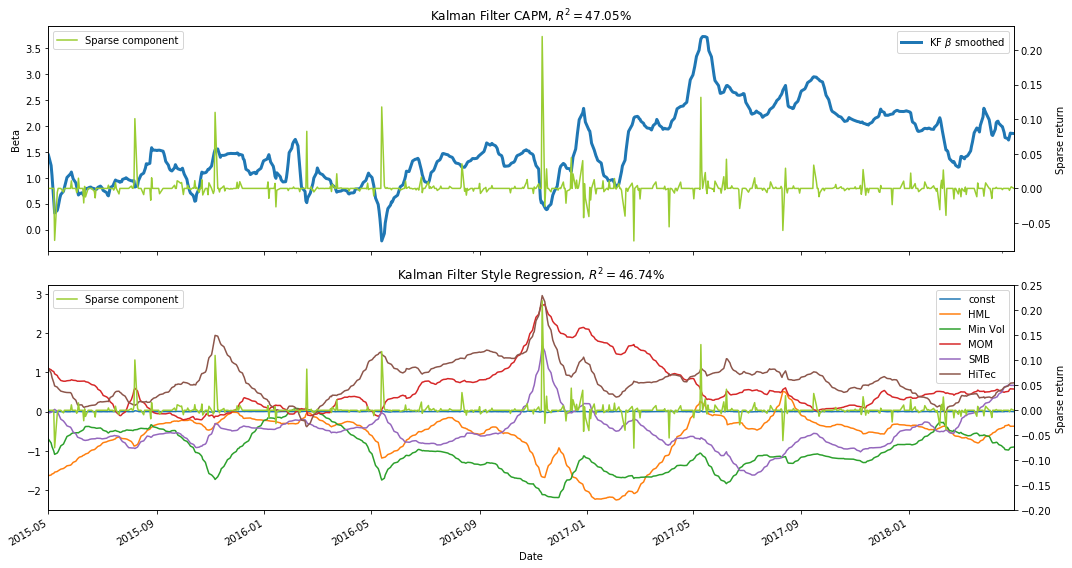

In [782]:
fig,ax = plt.subplots(2,1,figsize=(15,8))

capm_r_smooth['Mkt-RF'].plot(ax=ax[0],label=r'KF $\beta$ smoothed', 
                             title = 'Kalman Filter CAPM, $R^2 = %.2f$%%' % (r_sq_capm*100),
                             lw=3)
ax2 = ax[0].twinx()
sparse_vs_surprise.Sparse.plot(ax=ax2,color='yellowgreen',label = 'Sparse component')
ax[0].legend()
ax[0].set_ylabel('Beta')
ax2.legend(loc='upper left')
ax2.set_ylabel('Sparse return')

style_r_smooth.plot(ax=ax[1],
                   title = 'Kalman Filter Style Regression, $R^2 = %.2f$%%' % (r_sq_style*100))
ax3 = ax[1].twinx()
sparse_vs_surprise.Sparse.plot(ax=ax3,color='yellowgreen',label = 'Sparse component')
ax3.legend(loc='upper left')
ax3.set_ylabel('Sparse return')
ax3.set_ylim(-0.2, 0.25)
fig.tight_layout()

##### 6.2.3.2 Quarter shock adjustment - removing sparse component

Similar to the approach from the first draft of this research, the sparse return is generated using Robust PCA. The Robust PCA is performed against log returns of all tech stocks in the S&P 500 univers. The $\lambda$ is unchanged to be 0.1 to ensure sparsity (the higher, the more sparse). After the Nvidia's sparse return is retrieved, it will be subtracted from its raw return and the result will be feed into Kalman filter to perform online regression.

The results below indicate a good overall fit in the 'systematic' component with an $R^2$ of 58% in the CAPM case. The betas are less extreme at quarter end, especially at the second stage. This appears to be a better alternative than the bare-bone Kalman filter: more variance explained and a smoother beta.

In [728]:
## Training
Z, S = robustPCA(daily_log_ret_ticker.as_matrix(), lamb=0.1)
Z=pd.DataFrame(Z,index=daily_log_ret_ticker.index,columns=daily_log_ret_ticker.columns)
S=pd.DataFrame(S,index=daily_log_ret_ticker.index,columns=daily_log_ret_ticker.columns)

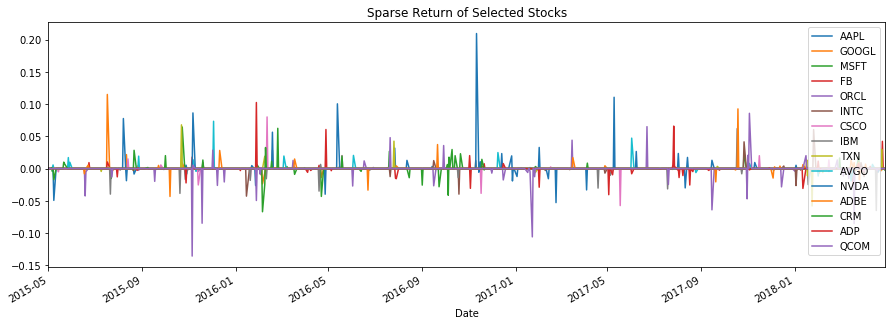

In [840]:
S[ticker_subset].plot(title='Sparse Return of Selected Stocks',figsize=(15,5))

In [784]:
## Two-stage Kalman filter with sparse component removed

capm_r_sparse_rv,_,r_sq_capm_sparse_rv,capm_resid_sparse_rv = \
    kf_regression(single_stock_ret-rf-S['NVDA'], 
                  excess_ret, 
                  single_capm_res.params,
                  single_capm_res.cov_HC0)
style_r_sparse_rv,_,r_sq_style_sparse_rv, resid_style_sparse_rv = \
    kf_regression(capm_resid_sparse_rv, 
                  style, 
                  single_style_ind_res.params,
                  single_style_ind_res.cov_HC0)

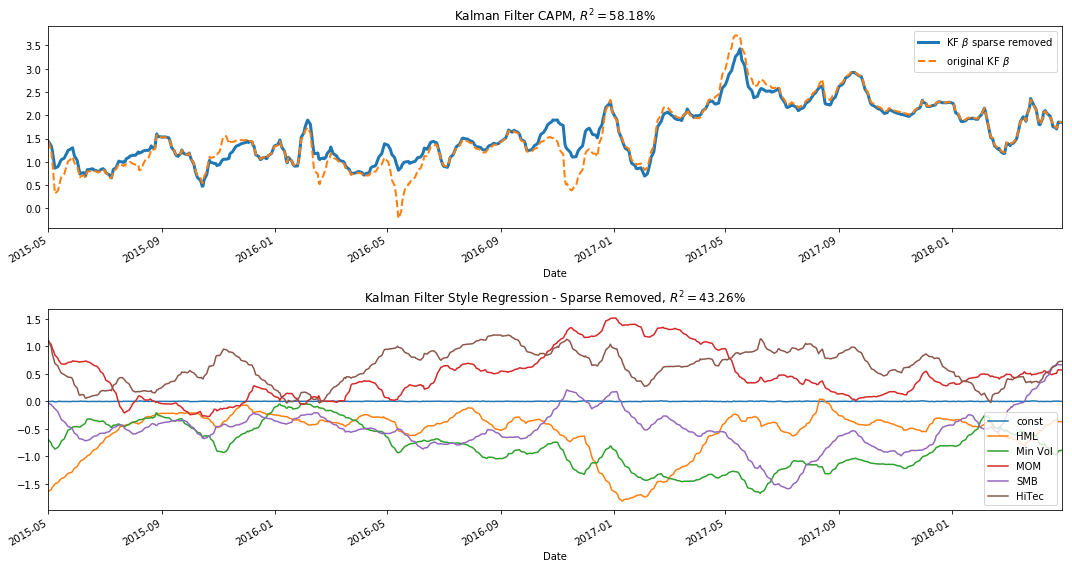

In [786]:
fig,ax = plt.subplots(2,1,figsize=(15,8))

capm_r_sparse_rv['Mkt-RF'].plot(ax=ax[0],label=r'KF $\beta$ sparse removed', 
                             title = 'Kalman Filter CAPM, $R^2 = %.2f$%%' % (r_sq_capm_sparse_rv*100),
                             lw=3)
capm_r_smooth['Mkt-RF'].plot(ax=ax[0],label=r'original KF $\beta$', 
                             style='--',
                             lw=2)
style_r_sparse_rv.plot(ax=ax[1],
                   title = 'Kalman Filter Style Regression - Sparse Removed, $R^2 = %.2f$%%' % (r_sq_style_sparse_rv*100))
ax[0].legend()
fig.tight_layout()

**Comment:** Removing sparse return in Kalman filter could be a systematic process rather than a specific application to Nvidia returns. They are essentially noise in the system, resulted from individual market event of different stocks at different times. These sparse returns should be studied separately as many may not have good way to explain in a systematic framework. In the section below of PCA application, the sparse returns are subtracted from the daily return of all stocks before running the two stage Kalman filter.

One may tempt to check for the significance of these beta estimates as well as their confidence interval. This can be tricky, as the hidden state $\beta_t$ is not a parameter estimate. It is almost a one-time estimate, akin to the transition covariance $\eta_t$ if assumed random walk. As a comparison, the $\hat\beta_{ols}$ is a estimate of the underlying true beta $\beta_{ols}$. It is $t$-distributed with error approaching 0 when sample is infinitely large. To my understanding, the setup is entirely different. Also there's no literature can be found online in testing significance of hidden states. However, significance testing is an interesting topic that might be fit to other parameters in Kalman filter. 

Frankly Kalman filter is an advance topic that requires experience and knowledge to fully grasp. There may be lots of places that can be improved in this model. It is an interesting topic which I will dig deeper in the future.

##### 6.2.3.3 Time series properties of two-stage Kalman filter residual

So far we have applied two stage Kalman filter online regression to the daily return series excess of sparse returns. The model has captured a decent amount of variation, and before moving further, it is worth spending a few minutes understanding the residual from the two stage process.

Sections below investigate its empirical distribution and serial correlation properties.  

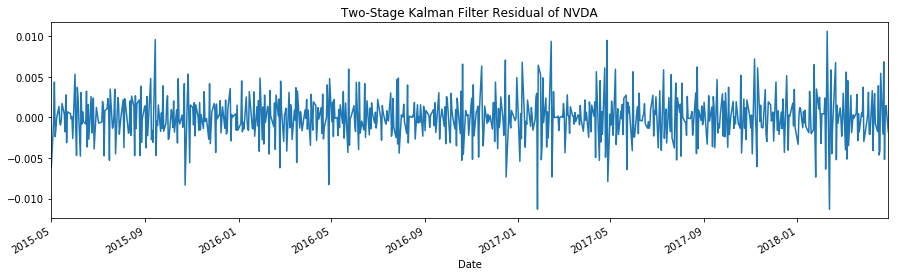

In [1184]:
resid_style_sparse_rv.plot(title='Two-Stage Kalman Filter Residual of NVDA', figsize=(15,4))

**Comment:** The chart above plots the residual time series. It looks in some way like white noise, oscillating around zero with no obvious volatility regime. After taking all the sparse component, some spikes remained in the series. The series is probably not normal, as these spikes leads to a fat tail distribution. This is confirmed by the series of stats and tests below.

In [1047]:
def print_stats(ret):
    print 'Mean: %.4f' % ret.mean()
    print 'Std: %.4f' % ret.std()
    print 'Skew: %.4f' % ret.skew()
    print 'Kurt: %.4f' % ret.kurt()
    
    fig = stats.probplot(ret, dist="norm", plot=pylab)    
    k2, p = stats.normaltest(ret.values)
    alpha = 1e-3
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
         print("The null hypothesis of Normality can be rejected")
    else:
         print("The null hypothesis of Normality cannot be rejected")
            
    shapiro_stats = stats.shapiro(ret.dropna().values)
    print 'Shaprio test: test stats - %.6f, pvalue - %.6f' % (shapiro_stats[0],shapiro_stats[1])

Mean: -0.0000
Std: 0.0028
Skew: 0.0173
Kurt: 1.2306
p = 2.59123e-05
The null hypothesis of Normality can be rejected
Shaprio test: test stats - 0.988900, pvalue - 0.000018


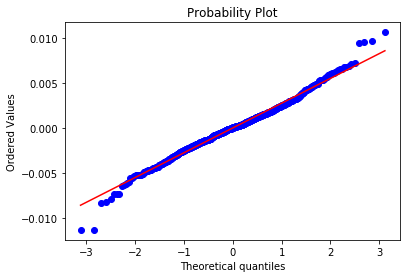

In [1048]:
print_stats(resid_style_sparse_rv)

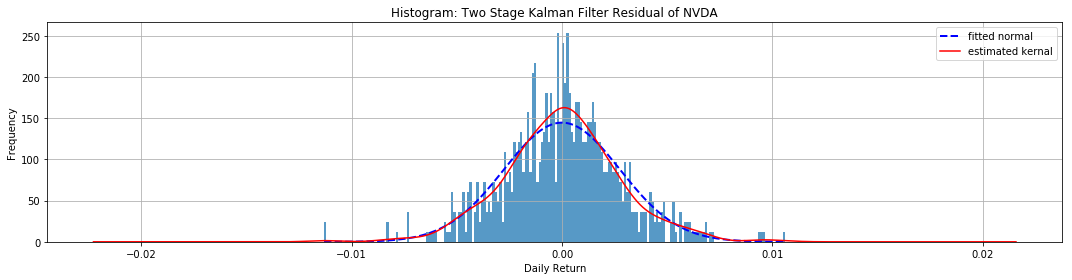

In [1043]:
fig, ax2 = plt.subplots(figsize=(15,4))

(mu,sigma)=stats.norm.fit(resid_style_sparse_rv)
n, bins, patches = plt.hist(resid_style_sparse_rv, 200, normed=1, alpha=0.75)

y=pylab.mlab.normpdf(bins, mu, sigma)
ax2.plot(bins, y, 'b--', linewidth=2, label = 'fitted normal')
resid_style_sparse_rv.plot(kind='kde',ax=ax2, color='r',label = 'estimated kernal')
ax2.legend()

ax2.set_ylabel('Frequency')
ax2.set_title('Histogram: Two Stage Kalman Filter Residual of NVDA')
ax2.set_xlabel('Daily Return')
ax2.grid(True)
fig.tight_layout()

**(following section):** Below plots the ACF and PACF of residual up to 20 lags. From the charts, it is reasonable to believe that the residual follows an MA($q$) process, and therefore not white noise. The value of $q$ is not so easily pinned down. I experimented different $q$, different intial values and solvers and finally came up with $q=3$, which yields a result with significant lag coefficients and stationary residuals. The result is shown in the sections below.

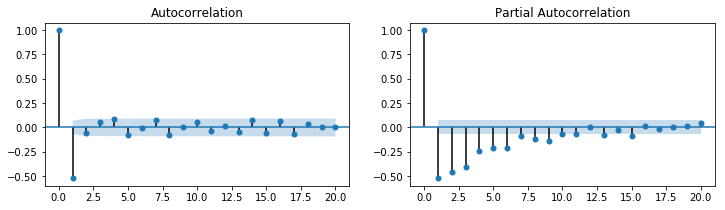

In [1108]:
fig,ax = plt.subplots(1,2,figsize=(12,3))
a = plot_acf(resid_style_sparse_rv, lags=20, ax=ax[0])
b = plot_pacf(resid_style_sparse_rv, lags=20, ax=ax[1])

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  755
Model:               SARIMAX(0, 0, 3)   Log Likelihood                3799.334
Date:                Thu, 28 Jun 2018   AIC                          -7590.667
Time:                        00:59:41   BIC                          -7572.160
Sample:                             0   HQIC                         -7583.538
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3239      0.029    -45.119      0.000      -1.381      -1.266
ma.L2          0.0983      0.046      2.125      0.034       0.008       0.189
ma.L3          0.2489      0.031      8.124      0.0

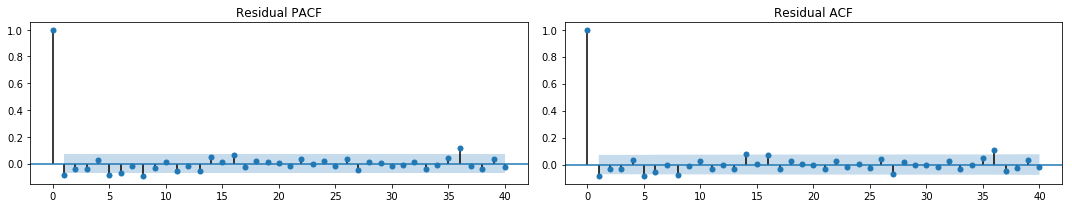

In [1109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(resid_style_sparse_rv, order=(0,0,3))#order=(0,0,3)
model_fit = model.fit(start_params=np.array([0.19,0.1,0.1,5e-06]))#np.array([0.19,0.1,0.1,5e-06])
print(model_fit.summary())

fig, ax3 = plt.subplots(1,2,figsize=(15,3))

plot_pacf(residuals_ret,ax=ax3[0],lags=40)
ax3[0].set_title('Residual PACF')

plot_acf(residuals_ret,ax=ax3[1],lags=40)
ax3[1].set_title('Residual ACF')

fig.tight_layout()

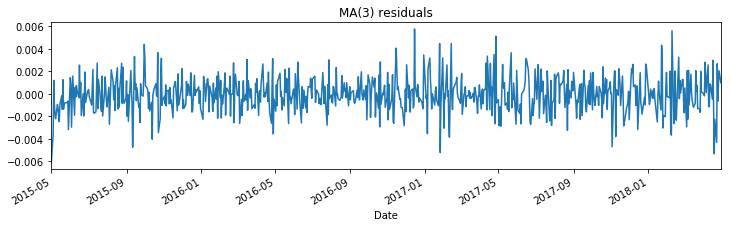

In [1110]:
residuals_ret = pd.Series(model_fit.resid)
residuals_ret.plot(label = 'residual',legend=False, title='MA(3) residuals',figsize=(12,3))

### 6.2 PCA for building latent factor

The most widely known technique of dimension reduction in finance is arguably PCA. It is a useful tool to extract and select statistical factors as additions to a multi-factor model. It first operates on the covariance matrix. A series of PC associated with high eigenvalue will then be selected as the statistical factors. 

In our case, the number of daily samples ($T=755$) are much greater than the total number of tech stocks ($N=74$). The covariance estimates should be reasonably accurate and any shrinkage seems unnecessary. In practice, many would also exponentially weight the data that gives declining weights to observations as they recede in the past. The intention is to get a more accurate measure of covariance for the most recent date, which is not the focus here as well. Therefore the implementation of PCA is in its purest form. 

The real challenge here is how much information can be extracted after the two-stage process. Another way to put it: how much PCA can still be of use if the correlation matrix is close to identity. Subsequently, how do we select PC factors if the top few only explains a small portion of covariation? Does it still make sense to use PCA? Sections below will examine these questions in more details.

Data used is the residual from the two stage Kalman filter with sparse return removed.

In [1099]:
if not read_from_exiting_output:
    
    kf_style_resid = {}

    for ticker in all_tech_tickers:
        _,_,_,kf_capm_resid = \
        kf_regression(daily_log_ret_ticker[ticker]-rf-S[ticker], 
                      excess_ret, 
                      capm_result[ticker].params,
                      capm_result[ticker].cov_HC0)

        _,_,_, kf_style_resid[ticker] = \
            kf_regression(kf_capm_resid_df, 
                          style, 
                          style_result[ticker].params,
                          style_result[ticker].cov_HC0)

    kf_style_resid = pd.DataFrame.from_dict(kf_style_resid)

In [1098]:
## pickle trained file to local
if not read_from_exiting_output:
    pd.to_pickle(kf_style_resid, PATH+'kf_style_resid')
else:
## read trained pickle file from local
    kf_style_resid = pd.read_pickle(PATH+'kf_style_resid')

**Comment:** below displays two heatmaps for correlations of the stocks in the tech sector, one for the original daily log return, the other for the residual return after the two stage process. The difference is *huge*. In the first chart the average correlation seem to be at around 0.5 with little variation cross sectionally, whereas the second charts shows a relatively sparse matrix. Decomposing a sparse matrix does not seem to help much. In the extreme case of a diagonal covariance matrix, the PC factors will just be the raw return themselves. If we were to regress raw return as these PC factors, it would just be the raw return regressing against itself! 

More realistically, the real problem is that the top factors can only explain a limited portion of covariation. Including too many factors in the model may very well overfit the data, let alone PC factors has little economic interpretability. This is a tough decision. As I do not have enough evidence to completely give up on PCA, I will select as few PCs factors as possible while ensuring certain explanation power.

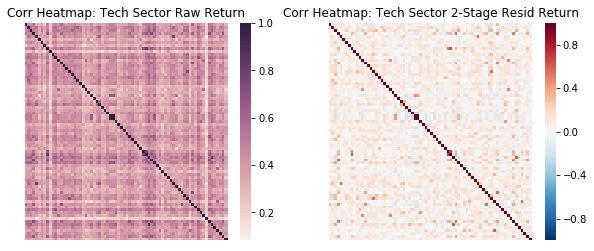

In [1107]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
sns.heatmap(daily_log_ret_ticker.corr(),ax=ax[0],xticklabels=False,yticklabels=False)
ax[0].set_title('Corr Heatmap: Tech Sector Raw Return')
sns.heatmap(kf_style_resid.corr(),ax=ax[1],xticklabels=False,yticklabels=False)
ax[1].set_title('Corr Heatmap: Tech Sector 2-Stage Resid Return')

**Comment:** As is seen below, the cumulative proportion of covariation explained increases in a very slow pace: it takes up to 9 factors to cover over 50% of variance. Generally, it would not be a good practice to include more PC factors then the real economically meaningful factors in a model. However it does not hurt to include one or two to add some explanation power. For completeness I chose the top 2 and run a regression of Nvidia's residual against these two PC factors

In [1128]:
from sklearn.decomposition import PCA

pca_sk = PCA(n_components=15).fit(kf_style_resid.values)

pca_summary = pd.DataFrame()
pca_summary['value'] = pca_sk.explained_variance_
pca_summary['Difference'] = pca_summary.value.diff(-1)
pca_summary['Proportion'] = pca_sk.explained_variance_ratio_
pca_summary['Cumulative Proportion'] = pca_summary.Proportion.cumsum()
pca_summary.index = pca_summary.index+1
pca_summary.round(6).head(10)

value  Difference  Proportion  Cumulative Proportion
1   0.000099    0.000027    0.116310               0.116310
2   0.000072    0.000005    0.084242               0.200552
3   0.000066    0.000025    0.077908               0.278459
4   0.000042    0.000001    0.049131               0.327590
5   0.000040    0.000008    0.047460               0.375050
6   0.000032    0.000003    0.038128               0.413179
7   0.000029    0.000004    0.034164               0.447342
8   0.000025    0.000003    0.029739               0.477082
9   0.000022    0.000000    0.025753               0.502834
10  0.000022    0.000003    0.025273               0.528108

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 28 Jun 2018   Prob (F-statistic):                nan
Time:                        01:32:12   Log-Likelihood:                 3073.3
No. Observations:                 755   AIC:                            -6141.
Df Residuals:                     752   BIC:                            -6127.
Df Model:                           2                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.946e-05      0.000     -0.130      0.8

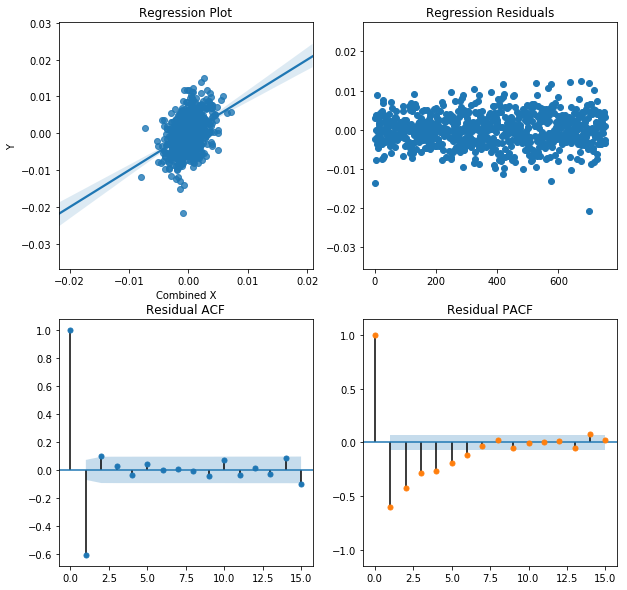

In [1140]:
pca_cov = multivariate.pca.PCA(kf_style_resid, standardize=False, demean=False)

for col in pca_cov.factors:
    stationarity_test(pca_cov.factors[col])
    
a = lin_reg(Y = kf_style_resid['NVDA'], X = pca_cov.factors.iloc[:,:2],print_plots=True,print_summary=True)

**Comment:** the beta for the second PC is in fact not significant. For completeness I run the regression with only the top factor and report the results below.

                            OLS Regression Results                            
Dep. Variable:                   NVDA   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 28 Jun 2018   Prob (F-statistic):                nan
Time:                        01:33:39   Log-Likelihood:                 3070.6
No. Observations:                 755   AIC:                            -6137.
Df Residuals:                     753   BIC:                            -6128.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.483e-05      0.000     -0.165      0.8

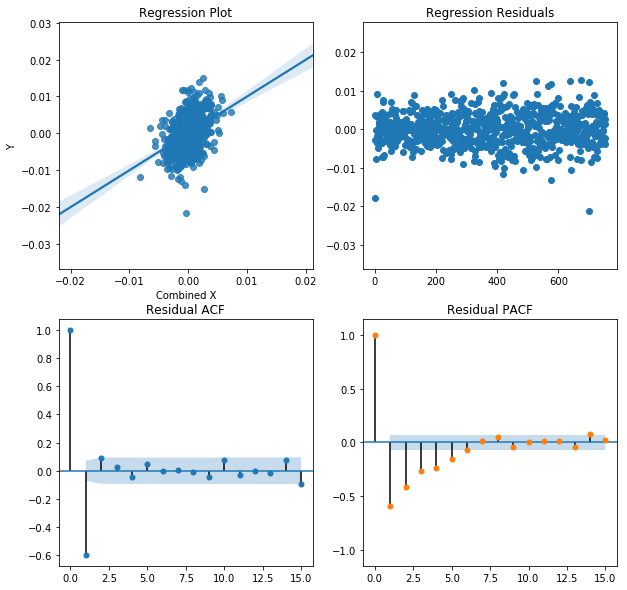

In [1141]:
a = lin_reg(Y = kf_style_resid['NVDA'], X = pca_cov.factors.iloc[:,:1],print_plots=True,print_summary=True)

**Comment:** the top PC factor explains rougly 17% of the variation. It is still a decent result, though below expectation of what normally PCA does. The regression residual shows some MA($q$) behavior. This is explained in section 6.2.3.3 as the exogenous variable can be modelled by a MA(3) process.

## 7. Summary of Extension

Guided by Future Steps in Section 5, I have explored different directions to push this research project further. In earning surprise modelling, I used the forward looking Leading Index for United States as a gauge for economic growth and identified months of economic expansion and slowdown. The state of expansion or slowdown could be a magnifier of earnings surprises and was used as a binary variable to add to the regression. At the first glance the regression result looked promising. However, data of longer history is needed to evaluate the 'magnifier' hypothesis further.

In two stage regression, I examined the three alternatives: rolling window OLS, rollling window RLM (using Huber T) and Kalman filter as online regression. In sample model fit were compared using $R^2$. Result showed that rolling window OLS and RLM shares similar $R^2$ but the latter produced steadier beta estimates as it is more robust to outliers. Kalman filter performed the best; its performance was improved after removing sparse return from the raw daily return data.

In extracting latent factors, the popular PCA was used. However, the residuals from the two-stage process exhibited limited correlation and as a result the PCA did not perform as well as expected. The variance explained by the top factors were lacking.

## 8. More Future Works

1. It might be interesting to investigate the predictability of these models. Bias-variance trade off would be a good topic to cover.
2. There is so much to explore in Kalman filter, e.g. significance test and parameter tuning. I would spend some time reading literatures to get a better understanding of this topic before blindly playing around with it.
3. There may very well be better method to extract latent factors. I thought about Factor Analysis (FA). But it seems to shine in case of insufficient data. There are papers of innovating techniques of low rank approximations. It would be interesting to get some exposre.
4. Other models for time varying beta includes Hamilton's regime switching model and MCMC. I tried MCMC in fact, but it took forever to run and it was not worth the time. But if I had the time and computer power I would love to explore more.